## Setup

### Importing Dependencies

In [1]:
# Data Loading
import pandas as pd

# Torch for training models
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel # For obtaining GPT-2 embeddings

# Mathematical libraries
import numpy as np
import math
import cmath
import random
from scipy import stats
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.utils import check_array
from sklearn.cluster import MiniBatchKMeans
import dcor

# Visualization and data saving
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import umap
import pickle

# Utitlties
from functools import partial

### Fixing Random Seeds for Reproducibility

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Selecting Project Directory

In [3]:
proj_dir = "QLens/" # Personalize if needed

## Loading and Preparing Datasets

In [4]:
df_file = '5_Core_Books_50k.tsv'
df = pd.read_csv(f"{proj_dir}{df_file}", sep='\t')

In [5]:
# Obtaining statistics of df
unique_titles = df['title:token'].unique()
num_items = len(unique_titles)
print(f"Filtered dataset has {num_items} unique items and {df['user_id:token'].nunique()} users.")

Filtered dataset has 185136 unique items and 42696 users.


### Constructing Dataset Splits

In [6]:
# Mapping book titles to new 0-based ids
title_to_id = pd.Series(np.arange(num_items), index=unique_titles).to_dict()
df['item_new_id'] = df['title:token'].map(title_to_id).astype(np.int64)

In [7]:
# Building per-user histories (list of item ids)
user_hist_series = df.groupby('user_id:token')['item_new_id'].apply(list) # pandas Series

user_histories = user_hist_series.tolist() # List of lists

In [8]:
# Creating data splits
train_set = [hist[:-2] for hist in user_histories]
val_set   = [hist[:-1] for hist in user_histories]
test_set  = [hist for hist in user_histories]

### Dataset Class

In [9]:
class BooksDataset(Dataset):
    def __init__(self, user_histories):
        # user_histories is a list of lists of ints (item ids)
        self.user_histories = user_histories

    def __len__(self):
        return len(self.user_histories)

    def __getitem__(self, idx):
        hist = self.user_histories[idx]

        return torch.tensor(hist, dtype=torch.long)

"""
collate_fn() prepares batches for processing by padding them

Args:
    batch (List of 1D LongTensors): Input batch to pad

Returns:
    padded_batch (LongTensor): Padded batch
"""
def collate_fn(batch, pad_token_id):
    padded = pad_sequence(batch, batch_first=True, padding_value=pad_token_id)

    return padded

## Loading Pretrained Base Model

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, init_embeddings_tensor, d_embedding, d_model, dim_feedforward, num_heads, dim_class, dropout_rate=0.1, max_seq_len = 275, pad_token_id=None):
        super().__init__()
        self.pad_token_id = pad_token_id

        # init_embeddings_tensor should be a FloatTensor of shape (num_embeddings, d_embedding)
        assert isinstance(init_embeddings_tensor, torch.Tensor)
        num_embeddings, emb_dim = init_embeddings_tensor.shape
        assert emb_dim == d_embedding

        # Creating the embedding layer initalizede to a copy of the input embeddings
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=d_embedding, padding_idx=self.pad_token_id)
        with torch.no_grad():
            self.embedding.weight.copy_(init_embeddings_tensor)

        # Positional Embedding Layer
        self.max_seq_len = max_seq_len
        self.pos_embedding = nn.Embedding(num_embeddings = max_seq_len, embedding_dim = d_model)
        nn.init.normal_(self.pos_embedding.weight, mean=0.0, std=0.02)

        # Model compression, attention, and MLP layers
        self.compression = nn.Linear(d_embedding, d_model)
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout_rate, batch_first=True)
        self.w1 = nn.Linear(d_model, dim_feedforward)
        self.attention_dropout = nn.Dropout(dropout_rate)
        self.w2 = nn.Linear(dim_feedforward, d_model)
        self.attention_norm = nn.LayerNorm(d_model)
        self.mlp_norm = nn.LayerNorm(d_model)
        self.w1_dropout = nn.Dropout(dropout_rate)
        self.w2_dropout = nn.Dropout(dropout_rate)

        # Classification layer over all valid items
        self.classification_layer = nn.Linear(d_model, dim_class)

        # Training trackers
        self.past_epochs = 0
        self.train_losses = []

    def forward(self, tokens, return_probs=True):

        x = self.embedding(tokens)  # (batch, seq_len, d_embedding)
        compressed = self.compression(x.float())

        # Positional Embeddings
        batch_len, seq_len = tokens.size()
        pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
        pos_embeds = self.pos_embedding(pos_ids)

        compressed = compressed + pos_embeds

        # Attention layer
        causal_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool, device=compressed.device), diagonal=1)
        key_padding_mask = (tokens == self.pad_token_id)
        attn_out = self.attention(compressed, compressed, compressed, attn_mask=causal_mask, key_padding_mask=key_padding_mask)[0]
        attn_out = attn_out.masked_fill(key_padding_mask.unsqueeze(-1), 0.0)

        y = compressed + self.attention_dropout(attn_out)
        y = self.attention_norm(y)

        # MLP Layer
        mlp_out = self.w1_dropout(nn.functional.gelu(self.w1(y)))
        mlp_out = self.w2_dropout(self.w2(mlp_out))
        y = y + mlp_out
        y = self.mlp_norm(y)

        # Final Classifcation layer
        final_logits = self.classification_layer(y)  # (batch, seq_len, dim_class)
        if not return_probs:
            return final_logits
        else:
            return nn.functional.softmax(final_logits, dim=-1)

    def train_model(self, train_dataloader, criterion, optimizer, num_epochs, device, proj_dir, scheduler=None):
        """
        Model training loop.

        Args:
            train_dataloader (DataLoader): DataLoader of training BooksDataset.
            criterion (torch.nn.loss): Loss function used to train model.
            optimizer (torch.optim): Training optimizer.
            num_epochs (int): Number of epochs to train for.
            device (torch.device): Device to train model on.
            proj_dir (str): Name of project directory to save checkpoints to.
            scheduler (torch.optim.lr_scheduler._LRScheduler or OneCycleLR, optional): If provided,
                will be used to adjust learning rate. If OneCycleLR, the learning
                rate will be stepped per-batch; otherwise once per epoch.
        """

        print("Starting training loop...")
        steps_per_epoch = len(train_dataloader) if hasattr(train_dataloader, '__len__') else None

        # Helper to determine whether scheduler expects per-batch stepping
        per_batch_scheduler = isinstance(scheduler, OneCycleLR)

        start_epoch = self.past_epochs
        for epoch in range(start_epoch, start_epoch + num_epochs):
            self.train()
            epoch_loss = 0.0

            # Progress bar for epoch
            for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{start_epoch + num_epochs}")):
                batch = batch.to(device)
                assert batch.dim() == 2

                # Preparing inputs and labels
                pad_mask = (batch != self.pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1)          # (B,)

                input_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                label_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                for i in range(batch.shape[0]):
                    input_tokens[i, :] = torch.cat((batch[i, :lengths[i] - 1], batch[i, lengths[i]:]))
                    label_tokens[i, :] = batch[i, 1:]

                input_tokens = input_tokens.to(torch.long)
                label_tokens = label_tokens.to(torch.long)

                # Zeroing the optimizer
                optimizer.zero_grad()

                # Obtaining logits
                logits = self(input_tokens, return_probs=False)
                b, s, v = logits.shape
                logits_flat = logits.reshape(-1, v)
                labels_flat = label_tokens.reshape(-1)

                # Computing loss
                loss = criterion(logits_flat, labels_flat)
                epoch_loss += loss.item()

                # Backpropagation
                loss.backward()
                optimizer.step()

                # Step per-batch scheduler (OneCycleLR MUST be stepped per batch)
                if per_batch_scheduler and (scheduler is not None):
                    scheduler.step()

            average_epoch_loss = epoch_loss / max(1, len(train_dataloader))
            self.train_losses.append(average_epoch_loss)

            # If scheduler is not a per-batch one, stepping it once per epoch
            if scheduler is not None and (not per_batch_scheduler):
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers (e.g., ReduceLROnPlateau) require a metric; skip here
                    pass

            # Obtaining current LR to print
            if scheduler is not None and hasattr(scheduler, "get_last_lr"):
                current_lr = float(scheduler.get_last_lr()[0])
            else:
                current_lr = float(optimizer.param_groups[0]['lr'])

            # Formating training tracker message
            msg = f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Average Loss: {average_epoch_loss:.4f}, Learning Rate: {current_lr:.6g}"

            # Intermediate evaluation on train set to get NDCG@10 and MRR metrics
            eval_results = self.eval_model(train_dataloader, criterion, device)
            ndcg10 = eval_results.get("NDCG@10", float("nan"))
            mrr = eval_results.get("MRR@10", float("nan"))
            msg += f", NDCG@10: {ndcg10:.4f}, MRR: {mrr:.4f}"

            print(msg)
            print('---\n')

        # Updating number of epochs that the model has been trained for
        self.past_epochs += num_epochs

        # Updating the positional embedding weight for sequence lengths longer than that in training
        with torch.no_grad():
            self.pos_embedding.weight[self.max_seq_len - 2] = self.pos_embedding.weight[self.max_seq_len - 3]
            self.pos_embedding.weight[self.max_seq_len - 1] = self.pos_embedding.weight[self.max_seq_len - 3]

        # Saving Checkpoint (include scheduler state if present)
        checkpoint = {
            'epoch': self.past_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': average_epoch_loss,
        }
        if scheduler is not None:
            try:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            except Exception:
                pass

        torch.save(checkpoint, proj_dir + f'model_checkpoint_{self.past_epochs}_epochs.pth')
        print(f"Checkpoint for Epoch {self.past_epochs} saved")

        # Visualzing loss vs epochs
        plt.figure()
        plt.plot(np.array(range(1, self.past_epochs + 1)), np.array(self.train_losses), "-o")
        plt.grid(True)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch Number")
        plt.savefig(proj_dir + "model_training_loss.png")
        plt.show()


    def eval_model(self, test_dataloader, criterion, device, k = 10):
        """
        Evaluates model using the last item per user on the following criteria:
          - average loss
          - Normalized Discounted Cumulative Gain at k (NDCG@k)
          - Mean Reciprocal Rank at k (MRR@k)

        Args:
            test_dataloader (DataLoader): Contains evaluation set batches.
            criterion (torch.nn.loss): Loss function to compute evaluation loss
            device (torch.device): Device to run evaluation on.
            k (int, optional): k value to compute NDCG@k for, defaults to 10.

        Returns:
            (dict): Contains average evaluation loss, NDCG@k, and MRR@k.
        """

        self.eval()

        val_loss = 0.0
        ndcg_total = 0.0
        rr_total = 0.0
        total_valid = 0  # Number of non-padded last items used in evaluation

        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Model Evaluation"):
                batch = batch.to(device)  # (batch, seq_len)

                # Preparing inputs and labels
                pad_mask = (batch != self.pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1)          # (B,)

                input_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                label_tokens = torch.zeros(batch.shape[0]).to(device)
                for i in range(batch.shape[0]):
                    input_tokens[i, :] = torch.cat((batch[i, :lengths[i] - 1], batch[i, lengths[i]:]))
                    label_tokens[i] = batch[i, lengths[i] - 1]

                input_tokens = input_tokens.to(torch.long)
                label_tokens = label_tokens.to(torch.long)

                logits = self(input_tokens, return_probs=False)  # (batch, seq_len-1, vocab_size)

                final_logits = torch.zeros([logits.shape[0], 1, logits.shape[2]]).to(device)
                for i in range(logits.shape[0]):
                    final_logits[i, :, :] = logits[i, lengths[i] - 2, :]

                final_logits = final_logits.squeeze(1)

                # Loss is only calculated on positions not containing the pad token
                try:
                    val_loss += criterion(final_logits, label_tokens).item()
                except Exception as e:
                    # Rare shape mismatch fallback: force shape
                    val_loss += criterion(final_logits, label_tokens.view(-1)).item()

                # Ranking for NDCG & MRR
                # Skipping ranking if pad token is seen in the labels
                valid_mask = (label_tokens != self.pad_token_id)  # shape (batch,)
                if valid_mask.sum().item() == 0:
                    continue

                # Computing top-k indices
                topk_vals, topk_idx = torch.topk(final_logits, k=k, dim=-1)  # (batch, k)

                # Iterating over all valid examples
                labels = label_tokens[valid_mask]
                topk_rows = topk_idx[valid_mask]  # shape (num_valid, k)
                num_valid = labels.size(0)

                for i in range(num_valid):
                    true_item = int(labels[i].item())
                    topk_row = topk_rows[i]

                    # Returns index of match (if present) between logits for i-th user and the true item
                    matches = (topk_row == true_item).nonzero(as_tuple=False)

                    if matches.numel() > 0:
                        rank_index = int(matches[0].item())  # Zero-based indexing is used within top-k
                        dcg = 1.0 / math.log2(rank_index + 2)  # 1-based rank is used in NDCG and MRR
                        rr = 1.0 / (rank_index + 1)
                    else:
                        dcg = 0.0
                        rr = 0.0

                    ndcg_total += dcg
                    rr_total += rr

                total_valid += num_valid

        # Computing averaged evaluation metrics
        avg_val_loss = val_loss / max(1, len(test_dataloader))
        avg_ndcg_at_k = ndcg_total / max(1, total_valid) if total_valid > 0 else 0.0
        avg_mrr_at_k = rr_total / max(1, total_valid) if total_valid > 0 else 0.0

        print(f"\nEvaluation Loss: {avg_val_loss:.4f}, NDCG@{k}: {avg_ndcg_at_k:.4f}, MRR@{k}: {avg_mrr_at_k:.4f}")

        return {
            "avg_val_loss": avg_val_loss,
            f"NDCG@{k}": avg_ndcg_at_k,
            f"MRR@{k}": avg_mrr_at_k
        }

In [11]:
# Selecting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_embeddings = torch.load(os.path.join(proj_dir, 'base_embeddings.pt'))  # shape (num_items+1, d_embedding)
init_embeddings = base_embeddings.float()

num_items = base_embeddings.shape[0] - 1  # Excluding pad row for classes
pad_idx = num_items

# Hyperparamters
d_embedding = base_embeddings.shape[1]
d_model = 128
num_heads = 4
d_ff = 512
batch_size = 8
num_epochs = 15
MAX_USER_INTER = 200

# Datasets
train_dataset = BooksDataset(train_set)
val_dataset  = BooksDataset(val_set)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, pad_token_id=pad_idx))
val_dataloader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=pad_idx))

model = TransformerModel(init_embeddings_tensor=init_embeddings,
                         d_embedding=d_embedding,
                         d_model=d_model,
                         dim_feedforward=d_ff,
                         num_heads=num_heads,
                         dim_class=num_items,  # number of real items
                         dropout_rate=0.1,
                         max_seq_len = MAX_USER_INTER,
                         pad_token_id=pad_idx)
    
model.to(device)

TransformerModel(
  (embedding): Embedding(185137, 768, padding_idx=185136)
  (pos_embedding): Embedding(200, 128)
  (compression): Linear(in_features=768, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (w1): Linear(in_features=128, out_features=512, bias=True)
  (attention_dropout): Dropout(p=0.1, inplace=False)
  (w2): Linear(in_features=512, out_features=128, bias=True)
  (attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (mlp_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (w1_dropout): Dropout(p=0.1, inplace=False)
  (w2_dropout): Dropout(p=0.1, inplace=False)
  (classification_layer): Linear(in_features=128, out_features=185136, bias=True)
)

In [12]:
# Loading model checkpoint
model_checkpoint_file = "model_checkpoint_20_epochs.pth"
model_checkpoint = torch.load(os.path.join(proj_dir, model_checkpoint_file))

# Loading model state dict
model_state_dict = model_checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## Loading Trained Tuned Lenses

### Submodel and Tuned Lens Classes

In [13]:
class EmbeddingModel(nn.Module):
# A component of the original Transformer consisting of only its embedding and compression layers
  def __init__(self, embedding, pos_embedding, compression):
    super(EmbeddingModel, self).__init__()

    # Initializing Layers
    self.embedding = embedding
    self.compression = compression

    # Positional Embedding Layer
    self.pos_embedding = pos_embedding

    # Freezing embedding_model parameters
    for param in self.parameters():
      param.requires_grad = False


  def forward(self, tokens):
    """
    Forward pass through embedding model

    Args:
        tokens (torch.Tensor): Contains input title IDs

    Returns:
        final_embeds (torch.Tensor): Contains final compressed embeddigs
    """

    # Embedding layer
    embeds = self.embedding(tokens)

    # Compression layer
    compressed_embeddings = self.compression(embeds.float())

    # Positional Embeddings
    batch_len, seq_len = tokens.size()
    pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
    pos_embeds = self.pos_embedding(pos_ids)

    # Combining Embeddings
    final_embeds = compressed_embeddings + pos_embeds

    return final_embeds

class AttentionModel(nn.Module):
# A component of the original Transformer consisting of only its embedding, compression, and attention layers
  def __init__(self, embedding, pos_embedding, compression, attention, pad_token_id = None):
    super(AttentionModel, self).__init__()

    # Initializing Layers
    self.embedding = embedding
    self.compression = compression
    self.pos_embedding = pos_embedding
    self.attention = attention

    # Setting pad token
    self.pad_token_id = pad_token_id

    # Freezing model parameters
    for param in self.parameters():
      param.requires_grad = False


  def forward(self, tokens):
    """
    Forward pass through attention model

    Args:
        tokens (torch.Tensor): Contains input title IDs

    Returns:
        res_stream (torch.Tensor): Residual stream state after the attention layer
    """

    # Embedding
    embeds = self.embedding(tokens)

    # Compression
    compressed_embeddings = self.compression(embeds)

    # Positional Embeddings
    batch_len, seq_len = tokens.size()
    pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
    pos_embeds = self.pos_embedding(pos_ids)

    # Combining Embeddings
    final_embeds = compressed_embeddings + pos_embeds

    # Attention
    seq_len = final_embeds.size(1)
    causal_mask = torch.triu(
                                torch.ones(seq_len, seq_len, device=final_embeds.device, dtype=torch.bool),
                                diagonal=1
                            )
    key_padding_mask = (tokens == self.pad_token_id)
    attention_output = self.attention(final_embeds, final_embeds, final_embeds, attn_mask = causal_mask, key_padding_mask = key_padding_mask)[0]

    # Residual Addition
    res_stream = final_embeds + attention_output

    return res_stream

In [14]:
class TunedLens(nn.Module):
    def __init__(self, d_model, last_norm, unembedding_layer, name, bias_only = True):
        super(TunedLens, self).__init__()
        self.bias = nn.Parameter(torch.zeros(d_model))  # shape (d_model,)
        self.layer_norm = last_norm
        self.unembedding = unembedding_layer
        self.name = name

        self.bias_only = bias_only
        # If not a bias only, a learnable weight matrix is also needed
        if not bias_only:
            self.weight_mat = nn.Parameter(torch.zeros(d_model, d_model))

        # freezing layer_norm and unembedding
        for param in self.layer_norm.parameters():
            param.requires_grad = False
        for param in self.unembedding.parameters():
            param.requires_grad = False

    def forward(self, x):
        """
        x: (B, S, d_model)
        adds bias and returns logits: (B, S, V)
        broadcasting of bias over batch and seq dims works via PyTorch broadcasting
        """

        if self.bias_only:
            z = x + self.bias  # broadcasts over last dim
        else:
            z = (x @ self.weight_mat) + self.bias

        z = self.layer_norm(z)
        logits = self.unembedding(z)  # (B, S, vocab_size)

        return logits

    def train_model(self,
                    train_dataloader,
                    criterion,
                    optimizer,
                    num_epochs,
                    device,
                    proj_dir,
                    sub_model,
                    final_model,
                    pad_token_id,
                    scheduler=None):
        """
        Trains the TunedLens.

        - train_dataloader yields batches of token ids -> shape (B, S)
        - sub_model and final_model are passed in and used in eval mode under no_grad()
        - scheduler may be per-batch (e.g., OneCycleLR) or per-epoch; this function
          automatically handles both. It prints the LR after each epoch.
        """
        self.to(device)
        train_losses = []

        # detect per-batch scheduler (OneCycleLR or _get_lr_called_within_step)
        per_batch_scheduler = scheduler is not None and hasattr(scheduler, "step") and getattr(scheduler, "_step_count", None) is not None and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR)

        # ensure teacher models are on device and in eval
        sub_model.to(device)
        final_model.to(device)
        sub_model.eval()
        final_model.eval()

        print("Starting TunedLens training loop...")

        for epoch in range(1, num_epochs + 1):
            self.train()
            epoch_loss = 0.0
            n_batches = 0

            for batch_tokens in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
                # batch_tokens: LongTensor (B, S) on CPU or pinned memory; move to device
                batch_tokens = batch_tokens.to(device)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    input_tokens[i, :] = torch.cat((batch_tokens[i, :lengths[i] - 1], batch_tokens[i, lengths[i]:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment

                # compute mask of non-pad tokens (True = valid)
                loss_pad_mask = (input_tokens != pad_token_id)  # (B, S)

                # compute teacher signals in no_grad
                with torch.no_grad():
                    residual = sub_model(input_tokens) # shape: (B, S, d_model)
                    final_logits = final_model(input_tokens, return_probs=False) # shape: (B, S, vocab)

                # forward lens (student)
                student_logits = self(residual)  # (B, S, vocab)

                # compute masked KL loss
                loss = criterion(final_logits.float(), student_logits, pad_mask=loss_pad_mask)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # if scheduler is per-batch (e.g., OneCycleLR) step every batch
                if scheduler is not None and per_batch_scheduler:
                    scheduler.step()

                epoch_loss += loss.item()
                n_batches += 1

            avg_epoch_loss = epoch_loss / max(1, n_batches)
            train_losses.append(avg_epoch_loss)

            # step epoch-based schedulers here
            if scheduler is not None and not per_batch_scheduler:
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers require a metric; we do not call those automatically
                    pass

            # print learning rate
            if scheduler is not None and hasattr(scheduler, "get_last_lr"):
                current_lr = float(scheduler.get_last_lr()[0])
            else:
                current_lr = float(optimizer.param_groups[0]['lr'])

            print(f"Epoch [{epoch}/{num_epochs}]  Avg Loss: {avg_epoch_loss:.6f}  LR: {current_lr:.6g}")

            # optional: small quick eval on train subset or val set can be triggered here

        # Save checkpoint
        checkpoint = {
            'epoch': num_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }
        if scheduler is not None:
            try:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            except Exception:
                pass

        torch.save(checkpoint, proj_dir + self.name + '_lens_checkpoint.pth')
        print(f"Checkpoint for Epoch {num_epochs} saved to {proj_dir + self.name + '_lens_checkpoint.pth'}")

        # Plot loss curve
        plt.figure()
        plt.plot(np.arange(1, num_epochs + 1), np.array(train_losses), "-o")
        plt.grid(True)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title(f"{self.name} Lens Loss")
        plt.savefig(proj_dir + self.name + "_lens_training_loss.png")
        plt.show()

        return train_losses

    def evaluate_model(self, test_dataloader, criterion, device, sub_model=None, final_model=None, pad_token_id=None):
        """
        Evaluate the TunedLens on batched test data.

        Returns avg loss and accuracy (agreement with teacher's top prediction).
        """
        self.to(device)
        self.eval()
        if sub_model is not None:
            sub_model.to(device)
            sub_model.eval()
        if final_model is not None:
            final_model.to(device)
            final_model.eval()

        total_loss = 0.0
        total_valid = 0
        total_matches = 0

        with torch.no_grad():
            for batch_tokens in tqdm(test_dataloader, desc=f"Eval {self.name} lens"):
                batch_tokens = batch_tokens.to(device)  # (B, S)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    input_tokens[i, :] = torch.cat((batch_tokens[i, :lengths[i] - 1], batch_tokens[i, lengths[i]:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment

                loss_pad_mask = (input_tokens != pad_token_id)

                residual = sub_model(input_tokens) # (B, S, d_model)
                teacher_logits = final_model(input_tokens, return_probs=False) # (B, S, V)
                student_logits = self(residual) # (B, S, V)

                # compute loss
                batch_loss = criterion(teacher_logits.float(), student_logits, pad_mask=loss_pad_mask)
                total_loss += batch_loss.item() * batch_tokens.size(0)  # weight by batch-size for averaging

                # Teacher logits for last valid position
                teacher_last = torch.zeros([teacher_logits.shape[0], 1, teacher_logits.shape[2]]).to(device)
                for i in range(teacher_logits.shape[0]):
                    teacher_last[i, :, :] = teacher_logits[i, lengths[i] - 2, :]
                teacher_last = teacher_last.squeeze(1)

                # Student logits for last valid position
                student_last = torch.zeros([student_logits.shape[0], 1, student_logits.shape[2]]).to(device)
                for i in range(student_logits.shape[0]):
                    student_last[i, :, :] = student_logits[i, lengths[i] - 2, :]
                student_last = student_last.squeeze(1)

                # Computing accuracy of top-1 on last position against teacher's top-1
                teacher_last_tok = teacher_last.argmax(dim=-1) # (B,)
                student_last_tok = student_last.argmax(dim=-1) # (B,)

                total_matches += (teacher_last_tok == student_last_tok).sum().item()
                total_valid += batch_tokens.size(0)

        avg_loss = total_loss / max(1, total_valid)
        accuracy = total_matches / max(1, total_valid)

        print(f"\nEval {self.name} Lens - Avg loss: {avg_loss:.6f}, Accuracy vs teacher (last pos): {accuracy:.4f}")
        return {"avg_val_loss": avg_loss, "accuracy": accuracy}

### Loading the Embedding Model and Tuned Lens

In [15]:
# Embedding model
embedding_model = EmbeddingModel(model.embedding, model.pos_embedding, model.compression).to(device)

# instantiate embedding lens
embedding_lens = TunedLens(d_model=d_model,
                           last_norm=model.mlp_norm,
                           unembedding_layer=model.classification_layer,
                           name='embedding',
                           bias_only = False).to(device)

In [16]:
# Loading embedding lens checkpoint
embedding_lens_checkpoint_file = "embedding_lens_checkpoint.pth"
embedding_lens_checkpoint = torch.load(os.path.join(proj_dir, embedding_lens_checkpoint_file))

# Loading embedding lens state dict
embedding_lens_state_dict = embedding_lens_checkpoint["model_state_dict"]
embedding_lens.load_state_dict(embedding_lens_state_dict)

<All keys matched successfully>

### Loading the Attention Model and Tuned Lens

In [17]:
# Attention model
attention_model = AttentionModel(model.embedding, model.pos_embedding, model.compression, model.attention, pad_idx).to(device)

# Instantiating the attention lens
attention_lens = TunedLens(d_model=d_model,
                           last_norm=model.mlp_norm,
                           unembedding_layer=model.classification_layer,
                           name='attention',
                           bias_only = False).to(device)

In [18]:
# Loading embedding lens checkpoint
attention_lens_checkpoint_file = "attention_lens_checkpoint.pth"
attention_lens_checkpoint = torch.load(os.path.join(proj_dir, attention_lens_checkpoint_file))

# Loading embedding lens state dict
attention_lens_state_dict = attention_lens_checkpoint["model_state_dict"]
attention_lens.load_state_dict(attention_lens_state_dict)

<All keys matched successfully>

## Analyzing Householder Reflection Vectors of Unitary Operators

### Preparing Householder Reflection Vectors

In [ ]:
def get_logits_for_position(batch_tokens, pos, device,
                            embedding_model, attention_model,
                            embedding_lens, attention_lens, model):
    """
    Return logits (B, S, V) for requested position:
      pos == 'embedding'  -> embedding_lens(embedding_model(batch_tokens))
      pos == 'attention'  -> attention_lens(attention_model(batch_tokens))
      pos == 'final'      -> model(batch_tokens, return_probs=False)
    All returned tensors are floats on device (not softmaxed yet).
    """

    if pos == 'embedding':
        # embedding_model -> (B,S,d_model); embedding_lens -> logits (B,S,V)
        residual = embedding_model(batch_tokens)      # ensure embedding_model handles batch on device
        logits = embedding_lens(residual)             # logits (B,S,V)
    elif pos == 'attention':
        residual = attention_model(batch_tokens)
        logits = attention_lens(residual)
    elif pos == 'final':
        # The transformer model's forward with return_probs=False returns logits shape (B,S,V)
        logits = model(batch_tokens, return_probs=False)
    else:
        raise ValueError("pos must be 'embedding', 'attention', or 'final'")

    return logits  # (B,S,V) on same device as model

def compute_last_idx_householder_vectors(
    dataset,
    batch_size=128,
    pos0='embedding',
    pos1='final',
    pad_idx=None,
    device=None,
    embedding_model=None,
    attention_model=None,
    embedding_lens=None,
    attention_lens=None,
    model=None,
    dtype=torch.float32,
    num_workers=4,
    pin_memory=True,
):
    """
    compute_last_idx_householder_vectors() derives the Householder normal vectors for the 
    last valid position in each input sequence while using batching.

    Args:
        dataset (BooksDataset): Dataset to compute Householder vectors for.
        batch_size (int): batch size for DataLoader
        pos0, pos1 (str): Determines which submodel and embedding lenes to use,
                        each can be one of 'embedding,' 'attention,' or 'final'.
        pad_idx (int): pad token id
        device (torch.device): torch device (e.g., torch.device('cuda'))
        embedding_model, attention_model, embedding_lens, attention_lens, model: Lens and submodels to compute Householder vectors with
        dtype (torch.dtype): dtype for intermediate computations
    Returns:
        all_hh_vecs (list of np.ndarray): A Python list of numpy arrays, each of which is a Householder vector 
                                        derived from the corresponding instance in the dataset.
        all_ket0_vecs (list of np.ndarray): A Python list of numpy arrays, each of which is the input state ket
    """

    assert device is not None, "Provide device"
    assert pad_idx is not None, "Provide pad_idx"
    assert model is not None and embedding_model is not None and attention_model is not None, "Provide models"
    # choose which lenses are not None
    assert embedding_lens is not None and attention_lens is not None, "Provide both embedding_lens and attention_lens"

    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                        num_workers=num_workers,
                        pin_memory=pin_memory)

    # make sure the teacher and lenses are in eval and on device
    model.to(device).eval()
    embedding_model.to(device).eval()
    attention_model.to(device).eval()
    embedding_lens.to(device).eval()
    attention_lens.to(device).eval()

    all_hh_vecs = []  # will append per-batch per-sample lists
    all_ket0_vecs = []

    chunk_idx = 0
    saved_chunks = []

    with torch.no_grad():
        for batch_tokens in tqdm(loader, desc="HH batch"):
            # move tokens to device
            batch_tokens = batch_tokens.to(device)

            # Preparing inputs
            pad_mask = (batch_tokens != pad_idx) # (B, S_total)
            lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

            # All but last token of each sequence is inputted into models
            input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
            for i in range(batch_tokens.shape[0]):
                for j in range(batch_tokens.shape[1]):
                    if j < lengths[i] - 1:
                        input_tokens[i, j] = batch_tokens[i, j]
                    elif j > lengths[i] - 1:
                        input_tokens[i, j - 1] = batch_tokens[i, j]

            input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment

            # compute logits for pos0 and pos1
            logits0 = get_logits_for_position(input_tokens, pos0, device,
                                              embedding_model, attention_model,
                                              embedding_lens, attention_lens, model)
            logits1 = get_logits_for_position(input_tokens, pos1, device,
                                              embedding_model, attention_model,
                                              embedding_lens, attention_lens, model)

            # Initial logits for last valid position in each sequence
            logits0_last = torch.zeros([logits0.shape[0], 1, logits0.shape[2]]).to(device)
            for i in range(logits0.shape[0]):
                logits0_last[i, :, :] = logits0[i, lengths[i] - 2, :]
            logits0_last = logits0_last.squeeze(1)

            # Final logits for last valid position in each sequence
            logits1_last = torch.zeros([logits1.shape[0], 1, logits1.shape[2]]).to(device)
            for i in range(logits1.shape[0]):
                logits1_last[i, :, :] = logits1[i, lengths[i] - 2, :]
            logits1_last = logits1_last.squeeze(1)

            # convert to probabilities in float (stable)
            probs0 = torch.softmax(logits0_last.to(dtype), dim=-1)  # (B, V)
            probs1 = torch.softmax(logits1_last.to(dtype), dim=-1)  # (B, V)

            # State vector construction
            ket0 = torch.sqrt(probs0.clamp(min=1e-30))
            ket1 = torch.sqrt(probs1.clamp(min=1e-30))

            # Householder extraction
            delta = ket1 - ket0
            norms = torch.linalg.norm(delta, dim=1, keepdim=True).clamp(min=1e-12)
            hh_flat = (delta / norms).cpu()  # (B, V)

            # Creating lists of Householder reflection vectors and input state kets
            hh_batch = []
            ket0_batch = []
            for i in range(hh_flat.shape[0]):
                hh_batch.append([hh_flat[i].cpu().numpy()])
                ket0_batch.append([ket0[i].cpu().numpy()])

            # hh_batch and ket0_batch are lists of length B of lists of numpy arrays
            all_hh_vecs.extend(hh_batch)
            all_ket0_vecs.extend(ket0_batch)


    return all_hh_vecs, all_ket0_vecs  # list-of-lists (len = dataset), each inner list contains one numpy array per interaction

In [20]:
# Dataset - sample of 5000 instances
test_set_5000 = random.sample(test_set, 5000)
unitary_dataset = BooksDataset(test_set_5000)

In [21]:
# Computing attention Householder reflection vectors
attention_hh_vecs, attention_ket0_vecs = compute_last_idx_householder_vectors(
    unitary_dataset,
    batch_size=4,
    pos0='embedding',
    pos1='attention',
    pad_idx=pad_idx,
    device=device,
    embedding_model=embedding_model,
    attention_model=attention_model,
    embedding_lens=embedding_lens,
    attention_lens=attention_lens,
    model=model,
    dtype=torch.float32,
    num_workers=4,
    pin_memory=True,
)

HH batch: 100%|██████████| 1250/1250 [00:51<00:00, 24.30it/s]


In [22]:
mlp_hh_vecs, mlp_ket0_vecs = compute_last_idx_householder_vectors(
    unitary_dataset,
    batch_size=4,
    pos0='attention',
    pos1='final',
    pad_idx=pad_idx,
    device=device,
    embedding_model=embedding_model,
    attention_model=attention_model,
    embedding_lens=embedding_lens,
    attention_lens=attention_lens,
    model=model,
    dtype=torch.float32,
    num_workers=4,
    pin_memory=True,
)

HH batch: 100%|██████████| 1250/1250 [00:51<00:00, 24.30it/s]


### PCA-based Analysis

In [ ]:
def efficient_pca(
    vec_source,
    plt_title = 'PCA Plot',
    file_name = 'pca.png',
    create_scatter = True,
    proj_dir="./QLens/",
    n_components=2,
    method="auto",
    batch_size=10000,
    dtype=np.float32,
    plot_max_points=50000,
    random_state=42,
    svd_iter=5,
):
    """
    efficient_pca() Perform PCA (efficiently) and creates a scatter-plot of the 
    first two components, if specified.

    Args:
        vec_source: Input vectors to perform PCA onone of:
            - numpy array shape (N, D).
            - list of numpy arrays (list of 2D arrays or list-of-1D arrays).
            - path to .npz/.npz chunk files where each file has 'data' = object array of per-sample vectors.
        plt_title (str): Title of resulting plot.
        file_name (str): Filename for saving the plot.
        create_scatter (bool): Whether to create a scatter plot of the first two PCA components, defaults to True.
        proj_dir (str): Directory to save the plot.
        n_components (int): number of PCA components to compute, defaults to 2.
        method (str): Selects the PCA method to use, one of "auto", "randomized", "incremental", or "truncated".
        batch_size (int): Used for batching in IncrementalPCA or when reading chunks from disk.
        dtype (np.dtype): dtype to use in calculations, defaults to np.float32.
        plot_max_points (int): Maxinum number of points to plot before random subsample goes into effect.
        random_state (int): Random state for PCA and subsampling (if applicable).
        svd_iter (int): The number of iterations used for randomized SVD (if used).
    Returns:
        X_pca (N,2) numpy array of projected points, pca_object (fitted sklearn transformer)
    """

    # Helper function generates batches of 2D numpy arrays from various vec_source types
    def batch_generator_from_source(src, batch_size):
        # Handling an input numpy array
        if isinstance(src, np.ndarray):
            N = src.shape[0]
            for i in range(0, N, batch_size):
                yield src[i:i+batch_size].astype(dtype, copy=False)
            return

        # Handling a list-like structure of arrays
        if isinstance(src, (list, tuple)):
            # If list of 1D arrays, they are stacked in batches
            idx = 0
            while idx < len(src):
                block = src[idx:idx+batch_size]
                # Converting each array to 2D if needed
                block2 = []
                for v in block:
                    a = np.asarray(v, dtype=dtype)
                    if a.ndim == 1:
                        a = a.reshape(1, -1)
                    block2.append(a)
                yield np.vstack(block2)
                idx += batch_size
            return

        # Handling a path or glob of .npz chunk files
        if isinstance(src, str) and os.path.exists(src):
            # Detecting a single .npz file or directory prefix
            if os.path.isfile(src) and src.endswith(".npz"):
                npz_files = [src]
            elif os.path.isdir(src):
                # Getting .npz files inside
                npz_files = sorted([os.path.join(src, f) for f in os.listdir(src) if f.endswith(".npz")])
            else:
                raise ValueError("vec_source string must be a .npz file or directory containing .npz files")

            for fn in npz_files:
                data = np.load(fn, allow_pickle=True)["data"]
                # Iterating over data in batches
                arrs = [np.asarray(x, dtype=dtype).reshape(1, -1) if np.asarray(x).ndim==1 else np.asarray(x, dtype=dtype) for x in data]
                idx = 0
                while idx < len(arrs):
                    block = arrs[idx:idx+batch_size]
                    yield np.vstack(block)
                    idx += batch_size
            return

        raise ValueError("Unsupported vec_source type")

    # Deciding the PCA method automatically if requested
    # Trying to estimate N and D if possible
    est_N = None
    est_D = None
    if isinstance(vec_source, np.ndarray):
        est_N, est_D = vec_source.shape
    elif isinstance(vec_source, (list, tuple)) and len(vec_source) > 0:
        # Inspecting first element
        first = np.asarray(vec_source[0])
        est_D = first.shape[-1]
        est_N = sum(1 if np.asarray(x).ndim==1 else np.asarray(x).shape[0] for x in vec_source)
    elif isinstance(vec_source, str) and os.path.exists(vec_source):
        # Leaving method selection flexible
        pass

    if method == "auto":
        if est_N is not None and est_D is not None:
            # Heuristic determination of method: if data is huge either in N or D, incremental/truncated PCA is preferred
            if est_N * est_D > 5e8:
                method_use = "incremental"
            elif est_D > 5000:
                method_use = "truncated"
            else:
                method_use = "randomized"
        else:
            method_use = "incremental"
    else:
        method_use = method

    # Fitting PCA / SVD
    if method_use == "randomized":
        # Loading all data into memory once (fast if it fits)
        if isinstance(vec_source, np.ndarray):
            X = vec_source.astype(dtype, copy=False)
        else:
            # Collecting data in batches and stacking
            blocks = []
            for block in batch_generator_from_source(vec_source, batch_size):
                blocks.append(block)
            X = np.vstack(blocks).astype(dtype, copy=False)
        pca = PCA(n_components=n_components, svd_solver="randomized", random_state=random_state, iterated_power=svd_iter)
        X_pca = pca.fit_transform(X)
        explained = pca.explained_variance_ratio_ * 100.0

    elif method_use == "incremental":
        ipca = IncrementalPCA(n_components=n_components)
        # First pass performs a partial_fit while using batching
        for block in batch_generator_from_source(vec_source, batch_size):
            block = check_array(block, dtype=dtype, ensure_2d=True)
            ipca.partial_fit(block)
        # Second pass transforms to obtain components
        transformed_blocks = []
        for block in batch_generator_from_source(vec_source, batch_size):
            block = check_array(block, dtype=dtype, ensure_2d=True)
            transformed_blocks.append(ipca.transform(block))
        X_pca = np.vstack(transformed_blocks)
        pca = ipca
        # Obtianing the explained variance ratio if available
        explained = getattr(ipca, "explained_variance_ratio_", None)
        if explained is not None:
            explained = explained * 100.0
        else:
            explained = [np.nan] * n_components

    elif method_use == "truncated":
        tsvd = TruncatedSVD(n_components=n_components, random_state=random_state, n_iter=svd_iter)
        # Feeding in either dense or sparse batches to TruncatedSVD
        if isinstance(vec_source, np.ndarray):
            X = vec_source.astype(dtype, copy=False)
            X_pca = tsvd.fit_transform(X)
        else:
            blocks = []
            for block in batch_generator_from_source(vec_source, batch_size):
                blocks.append(block)
            X = np.vstack(blocks)
            X_pca = tsvd.fit_transform(X)
        pca = tsvd
        explained = getattr(tsvd, "explained_variance_ratio_", [np.nan] * n_components)
        explained = np.array(explained) * 100.0

    else:
        raise ValueError("Unknown method_use: " + str(method_use))

    # Creating scatter plot if specified
    if create_scatter:
        # Subsampling data points if a large number are present
        N = X_pca.shape[0]
        if N > plot_max_points:
            rng = np.random.default_rng(random_state)
            keep = rng.choice(N, size=plot_max_points, replace=False)
            plot_pts = X_pca[keep]
        else:
            plot_pts = X_pca

        plt.figure(figsize=(7,6))
        plt.scatter(plot_pts[:, 0], plot_pts[:, 1], alpha=0.7, s=6)

        # Axes labels include explained variance if available
        if explained is not None and len(explained) >= 2 and not np.isnan(explained[0]):
            plt.xlabel(f"PC1 ({explained[0]:.1f}% var)")
            plt.ylabel(f"PC2 ({explained[1]:.1f}% var)")
        else:
            plt.xlabel("PC1")
            plt.ylabel("PC2")

        plt.title(plt_title)
        plt.grid(alpha=0.25)
        plt.tight_layout()

        # Creating directory to save scatter plot at if necessary
        os.makedirs(proj_dir, exist_ok=True)
        outpath = os.path.join(proj_dir, file_name)
        plt.savefig(outpath)
        plt.show()

    return X_pca, pca

In [24]:
attention_hh_vecs_array = np.array(attention_hh_vecs).squeeze(axis = 1)

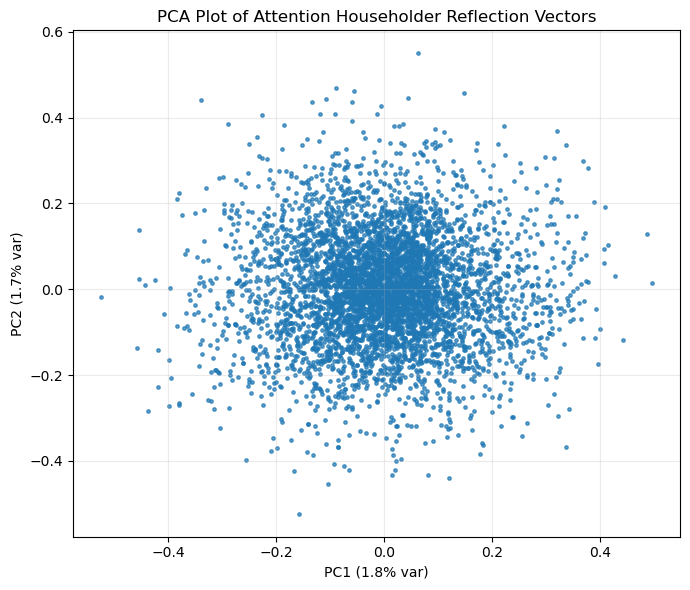

In [ ]:
attention_X_pca, attention_pca = efficient_pca(attention_hh_vecs_array,
                                                'PCA Plot of Attention Householder Reflection Vectors',
                                                'attention_hh_vecs_pca.png',
                                                proj_dir=proj_dir,
                                                method="randomized")

In [26]:
mlp_hh_vecs_array = np.array(mlp_hh_vecs).squeeze(axis = 1)

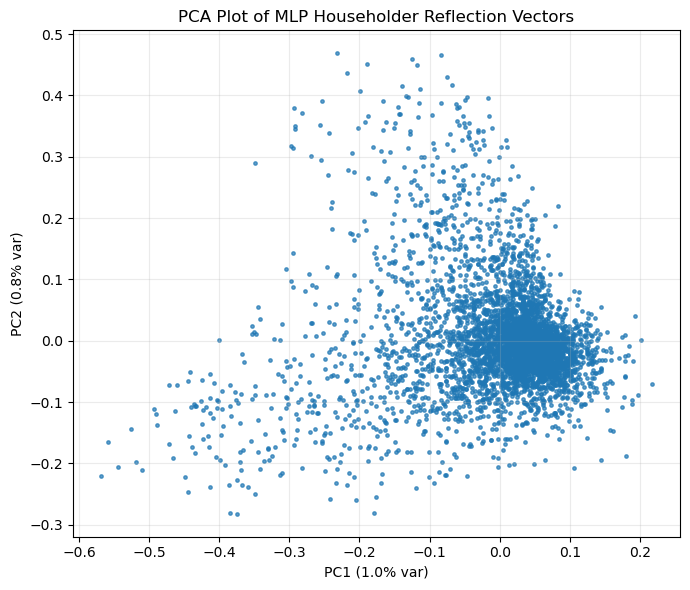

In [ ]:
mlp_X_pca, mlp_pca = efficient_pca(mlp_hh_vecs_array,
                                    'PCA Plot of MLP Householder Reflection Vectors',
                                    'mlp_hh_vecs_pca.png',
                                    proj_dir=proj_dir,
                                    method="randomized")

### Colored UMAP

In [ ]:
def create_vec_scatter_umap(
    vec_source,
    plt_title,
    file_name,
    color_labels = None,
    proj_dir="./QLens/",
    n_components=2,
    batch_size=10000,
    dtype=np.float32,
    plot_max_points=20000,
    random_state=42,
    # UMAP-specific
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",  # e.g., "cosine" for embeddings
    init="spectral",
    sample_fit_max=200000,  # subsample size used to fit UMAP; rest is streamed via transform
    target_metric=None,     # optional supervised embedding
    target=None,            # labels if supervised
):
    """
    create_vec_scatter_umap() performs UMAP efficiently on large datasets 
    and creates a scatter-plot of the first two components.

    It employs the following three step process:
      1. Build UMAP on a representative subsample (up to sample_fit_max).
      2. Transforming the remaining datapoints in batches.
      3. Creating scatter plot, subsampling as necessary to keep visualization responsive.

    Args:
        vec_source: The high dimensional vectors to plot, one of
            - a numpy array of shape (N, D).
            - a list of numpy arrays (list of 2D arrays or list-of-1D arrays).
            - a path to .npz files where each has 'data' = object array of per-sample vectors.
        plt_title (str): Title of resulting plot.
        file_name (str): Filename for saving the plot.
        color_labels (array-like): Optional array of length N for coloring points by cluster labels.
        proj_dir (str): Directory to save the plot.
        n_components (int): Number of UMAP components to project to, defaults to 2.
        batch_size: Used when reading data chunks and for transform streaming.
        dtype (torch.dtype): dtype used in computations, defaults to float32.
        plot_max_points (int): Maxinum number of points to plot before random subsample goes into effect.
        random_state (int): The Random seed for UMAP and subsampling, defaults to 42.
        UMAP hyperparams: n_neighbors, min_dist, metric, init, target_metric, target.
        sample_fit_max (int): The maximum number of samples to fit UMAP on (the rest are transformed).

    Returns:
        X_umap (np.ndarray of N, n_components): A numpy array of projected points.
        umap_obj: Fitted UMAP object.
    """

    # Helper function generates 2D numpy arrays as batches
    def batch_generator_from_source(src, batch_size):
        # Handling numpy arrays
        if isinstance(src, np.ndarray):
            N = src.shape[0]
            for i in range(0, N, batch_size):
                yield src[i:i+batch_size].astype(dtype, copy=False)
            return

        # Handling a list-like structure of arrays
        if isinstance(src, (list, tuple)):
            idx = 0
            while idx < len(src):
                block = src[idx:idx+batch_size]
                block2 = []
                for v in block:
                    a = np.asarray(v, dtype=dtype)
                    if a.ndim == 1:
                        a = a.reshape(1, -1)
                    block2.append(a)
                yield np.vstack(block2)
                idx += batch_size
            return

        # Handling a file path or glob of .npz chunk files
        if isinstance(src, str) and os.path.exists(src):
            if os.path.isfile(src) and src.endswith(".npz"):
                npz_files = [src]
            elif os.path.isdir(src):
                npz_files = sorted([os.path.join(src, f) for f in os.listdir(src) if f.endswith(".npz")])
            else:
                raise ValueError("vec_source string must be a .npz file or directory containing .npz files")

            for fn in npz_files:
                data = np.load(fn, allow_pickle=True)["data"]
                arrs = [
                    np.asarray(x, dtype=dtype).reshape(1, -1) if np.asarray(x).ndim == 1
                    else np.asarray(x, dtype=dtype)
                    for x in data
                ]
                idx = 0
                while idx < len(arrs):
                    block = arrs[idx:idx+batch_size]
                    yield np.vstack(block)
                    idx += batch_size
            return

        raise ValueError("Unsupported vec_source type")

    # First pass gathers a subsample to fit on
    fit_blocks = []
    fit_count = 0
    for block in batch_generator_from_source(vec_source, batch_size):
        block = check_array(block, dtype=dtype, ensure_2d=True)
        remaining = sample_fit_max - fit_count
        if remaining <= 0:
            break
        if block.shape[0] <= remaining:
            fit_blocks.append(block)
            fit_count += block.shape[0]
        else:
            fit_blocks.append(block[:remaining])
            fit_count += remaining
            break

    if fit_count == 0:
        raise ValueError("No data found for fitting UMAP.")

    X_fit = np.vstack(fit_blocks)

    # Optional supervised setup
    y_fit = None
    if target is not None:
        if isinstance(vec_source, np.ndarray) and isinstance(target, np.ndarray):
            y_fit = target[:X_fit.shape[0]]
        else:
            y_fit = target

    # Fitting UMAP on a subsample
    umap_obj = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        init=init,
        random_state=random_state,
        transform_seed=random_state,
        target_metric=target_metric,
        verbose=False,
    )

    umap_obj.fit(X_fit, y=y_fit)

    # Second pass transforms all data
    transformed_blocks = []
    for block in batch_generator_from_source(vec_source, batch_size):
        block = check_array(block, dtype=dtype, ensure_2d=True)
        transformed = umap_obj.transform(block)
        transformed_blocks.append(transformed)

    X_umap = np.vstack(transformed_blocks)

    # Creating the UMAP plot, while subsampling if large number of data points are present
    N = X_umap.shape[0]
    if N > plot_max_points:
        rng = np.random.default_rng(random_state)
        keep = rng.choice(N, size=plot_max_points, replace=False)
        plot_pts = X_umap[keep]
    else:
        plot_pts = X_umap

    plt.figure(figsize=(7, 6))

    # Determining whether to use color labels
    if color_labels is None:
        plt.scatter(plot_pts[:, 0], plot_pts[:, 1], alpha=0.7, s=6)
    else:
        plt.scatter(plot_pts[:, 0], plot_pts[:, 1], c=color_labels, cmap='tab20', alpha=0.7, s=6)

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(plt_title)
    plt.grid(alpha=0.25)
    plt.tight_layout()

    os.makedirs(proj_dir, exist_ok=True)
    outpath = os.path.join(proj_dir, file_name)
    plt.savefig(outpath)
    plt.show()

    return X_umap, umap_obj

#### Attention Layer

In [29]:
attention_hh_vecs_pca_dims = 3750
attention_hh_vecs_X_cluster_pca, attention_hh_vecs_cluster_pca = efficient_pca(attention_hh_vecs_array,
                                                                                create_scatter = False,
                                                                                method="randomized",
                                                                                n_components = attention_hh_vecs_pca_dims)

# Explained variance check
attention_hh_vecs_ex_var_ratio = attention_hh_vecs_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {attention_hh_vecs_pca_dims} dimensions: {(attention_hh_vecs_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 3750 dimensions: 93.4302%


In [30]:
def create_elbow_plot(data,
                      elbow_plt_title,
                      elbow_file_name,
                      min_clusters=5,
                      max_clusters=100,
                      step=1,
                      random_state=42):
    
    cluster_range = range(min_clusters, max_clusters + 1, step)

    inertia_values = []
    
    print(f"Starting MiniBatchKMeans fitting for number of clusters between {min_clusters} and {max_clusters}...")
    
    for n_clusters in tqdm(cluster_range, desc = 'Fitting clusters'):
        # Initializing MiniBatchKMeans with the current n_clusters
        kmeans = MiniBatchKMeans(
            n_clusters=n_clusters,
            random_state=random_state,
            n_init='auto',
            max_iter=30,
            verbose=0
        )

        # Fitting the model to the data
        kmeans.fit(data)
        labels = kmeans.labels_

        # Appending the inertia to the list
        inertia_values.append(kmeans.inertia_)

    # Creating elbow plot
    plt.figure(figsize=(10, 6))

    # Plotting the inertia values
    plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='blue')

    # Adding labels and title
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Total Inertia', fontsize=14)
    plt.title(elbow_plt_title, fontsize=16)

    # Formating for readability
    plt.xticks(np.arange(min_clusters, max_clusters + 1, step))
    plt.yticks(np.arange(min(inertia_values), max(inertia_values) + 1, 10))
    plt.tight_layout()

    # Saving plot
    plt.savefig(os.path.join(proj_dir, elbow_file_name))

    # Displaying plot
    plt.show()

Starting MiniBatchKMeans fitting for number of clusters between 5 and 150...


Fitting clusters: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it]


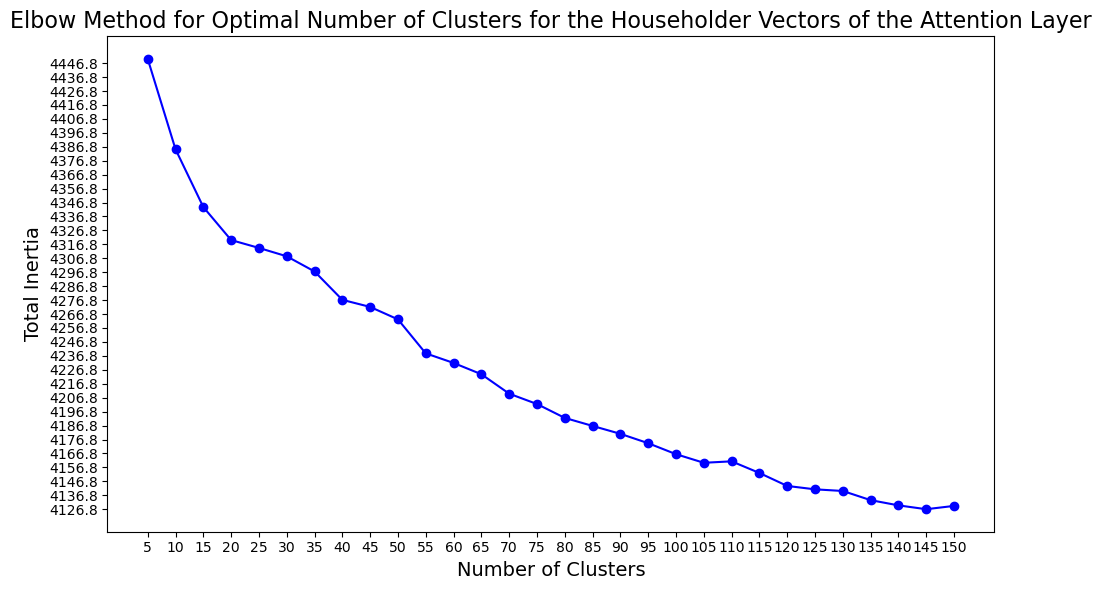

In [31]:
# Creating elbow plot for the Householder Vectors of the Attention Layer
create_elbow_plot(data = attention_hh_vecs_X_cluster_pca,
                    elbow_plt_title = 'Elbow Method for Optimal Number of Clusters for the Householder Vectors of the Attention Layer',
                    elbow_file_name = 'elbow_attention_hh_vecs.png',
                    min_clusters = 5,
                    max_clusters = 150,
                    step = 5)

In [35]:
attention_hh_vecs_X_cluster_pca = attention_hh_vecs_X_cluster_pca.astype('float64')

n_clusters_attention = 35
random_state_val = 42 # Set a random state for reproducibility

# Initializing MiniBatchKMeans
attention_hh_vecs_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters_attention,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
attention_hh_vecs_kmeans.fit(attention_hh_vecs_X_cluster_pca)

# Assigning each point to cluster
attention_hh_vecs_color_labels = attention_hh_vecs_kmeans.predict(attention_hh_vecs_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 4667.516365541945
[MiniBatchKMeans] Reassigning 3 cluster centers.
Minibatch step 1/146: mean batch inertia: 1.5121932705956538
[MiniBatchKMeans] Reassigning 3 cluster centers.
Minibatch step 2/146: mean batch inertia: 0.8836792855845041, ewa inertia: 0.8836792855845041
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch step 3/146: mean batch inertia: 0.8758394677190572, ewa inertia: 0.8804687382962746
[MiniBatchKMeans] Reassigning 3 cluster centers.
Minibatch step 4/146: mean batch inertia: 0.8714603473344973, ewa inertia: 0.8767796391781542
[MiniBatchKMeans] Reassigning 6 cluster centers.
Minibatch step 5/146: mean batch inertia: 0.8699449359561077, ewa inertia: 0.8739807045253345
Minibatch step 6/146: mean batch inertia: 0.8628664377333276, ewa inertia: 0.8694292111460042
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch step 7/146: mean batch inertia: 0.8631880578382954, ewa inertia: 0.8668733459242111
[MiniBatch

In [39]:
np.bincount(attention_hh_vecs_color_labels)

array([ 22, 202,  13,  14, 182,   6,   1, 239, 296,   1, 202,   1,  56,
       199,   1, 573, 258,  17, 324, 115, 684, 124,   1, 109, 148,   6,
       110,   1, 422, 167, 131, 215,   1,  86,  73])

/mmfs1/gscratch/stf/ipro13/conda_envs/quantum-conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


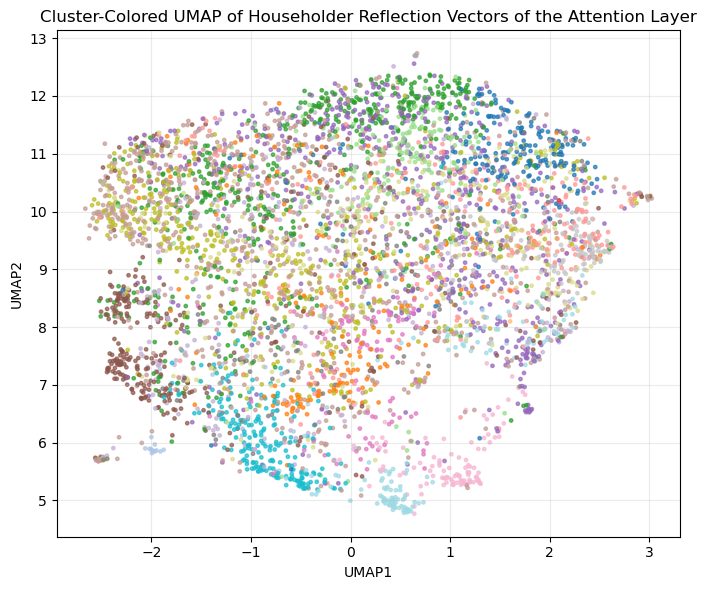

In [38]:
attention_clustered_hh_vecs_X_umap, attention_clustered_hh_vecs_umap = create_vec_scatter_umap(attention_hh_vecs_X_cluster_pca,
                                                                                              'Cluster-Colored UMAP of Householder Reflection Vectors of the Attention Layer',
                                                                                              'attention_hh_vecs_clustered_umap.png',
                                                                                              attention_hh_vecs_color_labels,
                                                                                              proj_dir = proj_dir)

##### Cluster Analysis

In [40]:
# Creating mapping from item IDs to titles
id_to_title = {v:k for k,v in title_to_id.items()}

In [41]:
def cluster_analysis(vec_array, labels, n_clusters):
    mean_cluster_cos_sims = []

    for cluster_id in range(n_clusters):
        cluster_indexes = np.where(labels == cluster_id)[0]
        cluster_vecs = vec_array[cluster_indexes, :]

        mean_cluster_vec = cluster_vecs.mean(axis=0)

        mean_cluster_vec_vals, mean_cluster_vec_item_idxs = torch.topk(torch.from_numpy(mean_cluster_vec), k = 10)

        print('Cluster ID: ', cluster_id)

        # Printing largest contributors to the average cluster Householder vector
        for k in range(mean_cluster_vec_vals.shape[0]):
            print(f'ID: {mean_cluster_vec_item_idxs[k]}, Title: {id_to_title[mean_cluster_vec_item_idxs[k].item()]}, Value: {mean_cluster_vec_vals[k]}')

        # Computing the mean cosine similarity between embeddings of the top titles in the average cluster Householder vector
        cluster_cosine_sims = []
        for i in range(mean_cluster_vec_vals.shape[0]):
            id_1 = mean_cluster_vec_item_idxs[i]

            with torch.no_grad():
                embed_1 = model.compression(model.embedding(torch.tensor([id_1], device = device)))

                for j in range(i + 1, mean_cluster_vec_vals.shape[0]):
                    id_2 = mean_cluster_vec_item_idxs[j]
                    embed_2 = model.compression(model.embedding(torch.tensor([id_2], device = device)))

                    cos_sim = nn.functional.cosine_similarity(embed_1, embed_2)
                    cluster_cosine_sims.append(cos_sim)

        mean_cluster_cosine_sim = sum(cluster_cosine_sims) / len(cluster_cosine_sims)
        mean_cluster_cos_sims.append(mean_cluster_cosine_sim)

        print('\n')
        print(f'Mean Cluster Embedding Cosine Similarity: {mean_cluster_cosine_sim.item():.4f}')
        print('---\n')

    return mean_cluster_cos_sims

In [42]:
# Attention cluster analysis - searching for cohesion in attention clusters
attention_mean_cluster_cos_sims = cluster_analysis(attention_hh_vecs_array,
                                                  attention_hh_vecs_color_labels,
                                                  n_clusters_attention)

Cluster ID:  0
ID: 26888, Title: The Art of Pixar: 25th Anniv.: The Complete Color Scripts and Select Art from 25 Years of Animation, Value: 0.020250670611858368
ID: 2047, Title: Maze Runner. Correr o Morir / Maze Runner, Run or die (Spanish Edition), Value: 0.020162640139460564
ID: 40395, Title: A Constellation of Vital Phenomena, Value: 0.0176748875528574
ID: 36693, Title: Wicked Season (An Ivy Morgan Mystery) (Volume 7), Value: 0.017666922882199287
ID: 10752, Title: Daughter of Smoke &amp; Bone, Value: 0.01726391725242138
ID: 677, Title: Heir of Fireno. 3 (Throne of Glass), Value: 0.01712563820183277
ID: 3307, Title: Ready Player One, Value: 0.016108710318803787
ID: 20205, Title: The Queen of the Tearling: A Novel (Queen of the Tearling, The), Value: 0.01383060123771429
ID: 4224, Title: The Martian, Value: 0.01381651684641838
ID: 74123, Title: The Archived, Value: 0.013371882028877735


Mean Cluster Embedding Cosine Similarity: 0.5724
---

Cluster ID:  1
ID: 2257, Title: The Fix (Me

In [43]:
mean_attention_cluster_cos_sim_cohesion = sum(attention_mean_cluster_cos_sims) / len(attention_mean_cluster_cos_sims)
print(f'Mean Attention Cluster Cohesion (via Cosine Similarity between Title Embeddings): {mean_attention_cluster_cos_sim_cohesion.item():.4f}')

Mean Attention Cluster Cohesion (via Cosine Similarity between Title Embeddings): 0.6527


In [44]:
def get_mean_rand_cluster_embedding_sim(layer_hh_vecs, orig_labels, n_clusters, k = 10):
    rand_cluster_cos_sims = []
    rand_labels = np.random.permutation(orig_labels)

    for rand_cluster_id in range(n_clusters):
        rand_idxs = np.where(rand_labels == rand_cluster_id)[0]
        rand_cluster_vecs = layer_hh_vecs[rand_idxs, :]

        mean_cluster_hh_vec = rand_cluster_vecs.mean(axis = 0)
        mean_cluster_hh_vec_vals, mean_cluster_hh_vec_item_idxs = torch.topk(torch.from_numpy(mean_cluster_hh_vec), k = k)

        cluster_cosine_sims = []
        for i in range(mean_cluster_hh_vec_vals.shape[0]):
            id_1 = mean_cluster_hh_vec_item_idxs[i]

            with torch.no_grad():
                embed_1 = model.compression(model.embedding(torch.tensor([id_1], device = device)))

                for j in range(i + 1, mean_cluster_hh_vec_vals.shape[0]):
                    id_2 = mean_cluster_hh_vec_item_idxs[j]
                    embed_2 = model.compression(model.embedding(torch.tensor([id_2], device = device)))

                    cos_sim = nn.functional.cosine_similarity(embed_1, embed_2)
                    cluster_cosine_sims.append(cos_sim)

        mean_cluster_cosine_sim = sum(cluster_cosine_sims) / len(cluster_cosine_sims)
        rand_cluster_cos_sims.append(mean_cluster_cosine_sim)

    mean_rand_cluster_cos_sim = sum(rand_cluster_cos_sims) / len(rand_cluster_cos_sims)

    return mean_rand_cluster_cos_sim.item()

In [45]:
# Comparing cohesion in Attention clusters against random baseline
mean_attention_rand_cluster_embedding_sim = get_mean_rand_cluster_embedding_sim(attention_hh_vecs_array,
                                                                                attention_hh_vecs_color_labels,
                                                                                n_clusters_attention)

print(f'Random Baseline for Attention Cluster Cohesion: {mean_attention_rand_cluster_embedding_sim:.4f}')

Random Baseline for Attention Cluster Cohesion: 0.5796


In [46]:
def cluster_cohesion_test(test_vecs, test_labels, test_clusters, test_value, n_trials = 100):
    count = 0
    for trial in tqdm(range(n_trials), desc = 'Running permutations'):
        rand_cluster_cohesion = get_mean_rand_cluster_embedding_sim(attention_hh_vecs_array,
                                                                    attention_hh_vecs_color_labels,
                                                                    n_clusters_attention)

        if rand_cluster_cohesion > test_value:
            count += 1

    p_val = (count + 1) / (n_trials + 1) # Plus one-smoothing is used

    return p_val

In [47]:
# Computing P-value of attention hh_vecs cohesion against randomized baseline
attention_hh_vecs_cohesion_p_val = cluster_cohesion_test(attention_hh_vecs_array,
                                                        attention_hh_vecs_color_labels,
                                                        n_clusters_attention,
                                                        mean_attention_cluster_cos_sim_cohesion.item())
print(f'Attention Householder Reflection Vectors Cluster Cohesion P-value: {attention_hh_vecs_cohesion_p_val:.4f}')

Running permutations: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]

Attention Householder Reflection Vectors Cluster Cohesion P-value: 0.0099


#### MLP Layer

In [48]:
mlp_hh_vecs_pca_dims = 3750
mlp_hh_vecs_X_cluster_pca, mlp_hh_vecs_cluster_pca = efficient_pca(mlp_hh_vecs_array,
                                                                    create_scatter = False,
                                                                    method="randomized",
                                                                    n_components = mlp_hh_vecs_pca_dims)

# Explained variance check
mlp_hh_vecs_ex_var_ratio = mlp_hh_vecs_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {mlp_hh_vecs_pca_dims} dimensions: {(mlp_hh_vecs_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 3750 dimensions: 91.5177%


Starting MiniBatchKMeans fitting for number of clusters between 5 and 150...


Fitting clusters: 100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


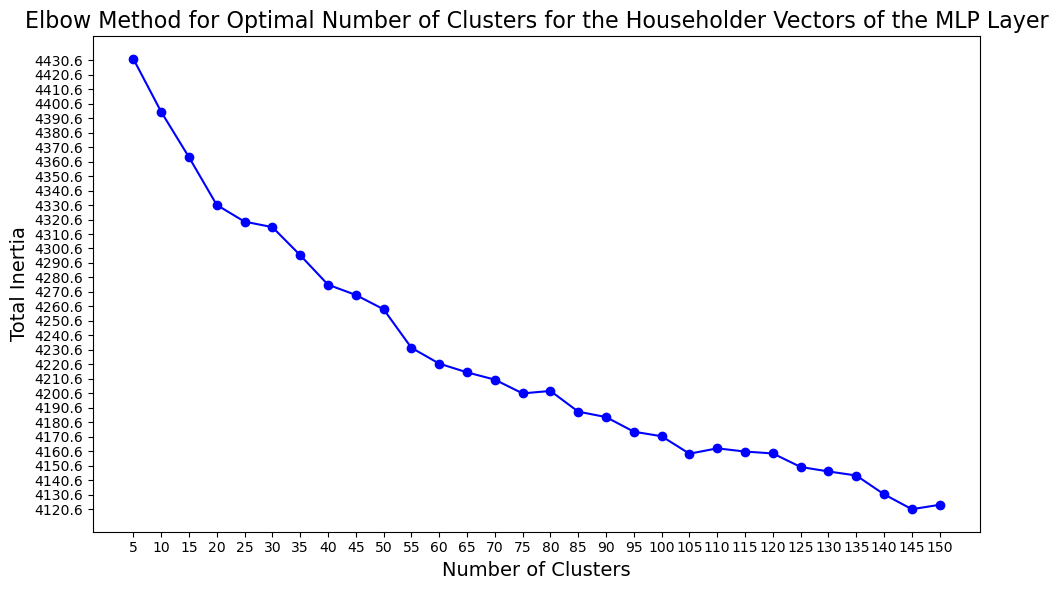

In [49]:
# Creating elbow plot for the Householder Vectors of the Attention Layer
create_elbow_plot(data = mlp_hh_vecs_X_cluster_pca,
                    elbow_plt_title = 'Elbow Method for Optimal Number of Clusters for the Householder Vectors of the MLP Layer',
                    elbow_file_name = 'elbow_mlp_hh_vecs.png',
                    min_clusters = 5,
                    max_clusters = 150,
                    step = 5)

In [73]:
mlp_hh_vecs_X_cluster_pca = mlp_hh_vecs_X_cluster_pca.astype('float64')

n_clusters_mlp = 25

# Initializing MiniBatchKMeans
mlp_hh_vecs_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters_mlp,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
mlp_hh_vecs_kmeans.fit(mlp_hh_vecs_X_cluster_pca)

# Assigning each point to cluster
mlp_hh_vecs_color_labels = mlp_hh_vecs_kmeans.predict(mlp_hh_vecs_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 4808.180060880148
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 1/146: mean batch inertia: 1.5538758335484217
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch step 2/146: mean batch inertia: 0.8833355483201124, ewa inertia: 0.8833355483201124
Minibatch step 3/146: mean batch inertia: 0.8750833524169186, ewa inertia: 0.8799561247628755
[MiniBatchKMeans] Reassigning 5 cluster centers.
Minibatch step 4/146: mean batch inertia: 0.8721500609619823, ewa inertia: 0.8767594003749073
Minibatch step 5/146: mean batch inertia: 0.8737503281837782, ewa inertia: 0.8755271308593239
Minibatch step 6/146: mean batch inertia: 0.8709740656516614, ewa inertia: 0.8736625682627845
Minibatch step 7/146: mean batch inertia: 0.869892537776893, ewa inertia: 0.8721186725549049
[MiniBatchKMeans] Reassigning 5 cluster centers.
Minibatch step 8/146: mean batch inertia: 0.8666643440162286, ewa inertia: 0.8698850263147111
[MiniBatchKMean

In [74]:
np.bincount(mlp_hh_vecs_color_labels)

array([   1,  170,  205,  368,  135,  158,  439,  215,  322,  154,  150,
          3,  161,  144,    1, 1608,    1,   30,  258,  123,    1,   83,
         86,    2,  182])

/mmfs1/gscratch/stf/ipro13/conda_envs/quantum-conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


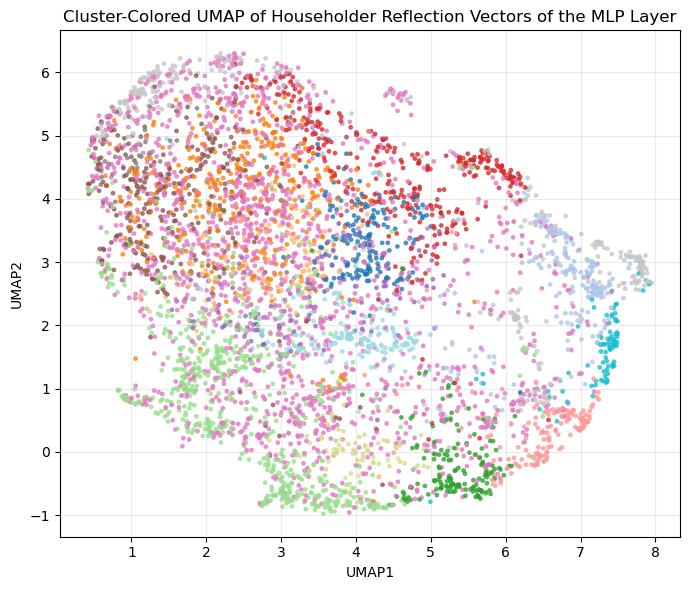

In [75]:
mlp_clustered_hh_vecs_X_umap, mlp_clustered_hh_vecs_umap = create_vec_scatter_umap(mlp_hh_vecs_X_cluster_pca,
                                                                              'Cluster-Colored UMAP of Householder Reflection Vectors of the MLP Layer',
                                                                              'mlp_hh_vecs_clustered_umap.png',
                                                                              mlp_hh_vecs_color_labels,
                                                                              proj_dir = proj_dir)

##### Cluster Analysis

In [76]:
# MLP cluster analysis - searching for cohesion in MLP clusters
mlp_mean_cluster_cos_sims = cluster_analysis(mlp_hh_vecs_array,
                                            mlp_hh_vecs_color_labels,
                                            n_clusters_mlp)

Cluster ID:  0
ID: 175460, Title: Sleep My Valley, Value: 0.4157804548740387
ID: 120663, Title: You Don't Know What Love Is, Value: 0.30285149812698364
ID: 120655, Title: The Medium, Value: 0.19832660257816315
ID: 159737, Title: Three Voices, Value: 0.07786144316196442
ID: 92418, Title: Escape from Behruz, Value: 0.07603953778743744
ID: 91061, Title: Journey to Water's Heart, Value: 0.06728148460388184
ID: 33225, Title: Snow on Cinders (The Tallas Series) (Volume 2), Value: 0.05774810537695885
ID: 32670, Title: How to Live In a Car, Van, or RV: And Get Out of Debt, Travel, and Find True Freedom, Value: 0.0550263412296772
ID: 34029, Title: I'm Not From Around Here, Value: 0.04626409336924553
ID: 178119, Title: A Prince Among Men (Red, Hot &amp; Blue), Value: 0.04239695891737938


Mean Cluster Embedding Cosine Similarity: 0.6925
---

Cluster ID:  1
ID: 1357, Title: Don't Let Go, Value: 0.03140093758702278
ID: 6662, Title: The Naturalist, Value: 0.028845693916082382
ID: 2269, Title: The R

In [77]:
mean_mlp_cluster_cos_sim_cohesion = sum(mlp_mean_cluster_cos_sims) / len(mlp_mean_cluster_cos_sims)
print(f'Mean MLP Cluster Cohesion (via Cosine Similarity between Title Embeddings): {mean_mlp_cluster_cos_sim_cohesion.item():.4f}')

Mean MLP Cluster Cohesion (via Cosine Similarity between Title Embeddings): 0.6815


In [78]:
# Comparing cohesion in MLP clusters against random baseline
mean_mlp_rand_cluster_embedding_sim = get_mean_rand_cluster_embedding_sim(mlp_hh_vecs_array,
                                                                          mlp_hh_vecs_color_labels,
                                                                          n_clusters_mlp)

print(f'Random Baseline for MLP Cluster Cohesion: {mean_mlp_rand_cluster_embedding_sim:.4f}')

Random Baseline for MLP Cluster Cohesion: 0.5785


In [79]:
# Computing P-value of attention hh_vecs cohesion against randomized baseline
mlp_hh_vecs_cohesion_p_val = cluster_cohesion_test(mlp_hh_vecs_array,
                                                  mlp_hh_vecs_color_labels,
                                                  n_clusters_mlp,
                                                  mean_mlp_cluster_cos_sim_cohesion.item())
print(f'MLP Householder Reflection Vectors Cluster Cohesion P-value: {mlp_hh_vecs_cohesion_p_val:.4f}')

Running permutations: 100%|██████████| 100/100 [02:53<00:00,  1.74s/it]

MLP Householder Reflection Vectors Cluster Cohesion P-value: 0.0099


## Analysis of Frobenius Similarities

### Permutation Tests for the Frobenius Similarity of Unitary Operators

In [80]:
def get_random_hh_vecs(dim_vecs, num_vecs):
    phi_0_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_0_vecs = phi_0_vecs / np.linalg.norm(phi_0_vecs, axis=1, keepdims=True)

    phi_1_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_1_vecs = phi_1_vecs / np.linalg.norm(phi_1_vecs, axis=1, keepdims=True)

    hh_vecs = []
    for i in range(phi_0_vecs.shape[0]):
        hh = phi_1_vecs[i, :] - phi_0_vecs[i, :]
        hh = hh / np.linalg.norm(hh)

        hh_vecs.append(hh)

    hh_vecs = np.asarray(hh_vecs)

    return hh_vecs

In [81]:
'''
mean_from_sim_submatrix() returns the mean pairwise similarity
computed from an input simularity (or Gram) submatrix.

    Args:
        sim_submatrix (torch.Tensor): Square matrix to compute mean similarities from.

    Returns:
        (float): Mean pairwise similarity from the input matrix.
'''
def mean_from_sim_submatrix(sim_submatrix: torch.Tensor) -> float:

    # Shape check
    n = sim_submatrix.shape[0]
    if n < 2:
        return float("nan")

    # Summing unique off-diagonal elements to get all unique pairwise similarities
    # All entries with row < collumn are effectiely summed
    total = sim_submatrix.sum()
    diag = sim_submatrix.diag().sum()
    sum_offdiag = (total - diag) / 2.0

    # Total number of elements
    denom = n * (n - 1) / 2.0

    return (sum_offdiag / denom).item()

'''
permutation_test_precompute() conducts a permutation test to determine the
statistical significance of an observed difference in mean pairwise Frobenius
cosine similarities between unitary operators or Hamiltonians dervided from a
test set of Householder reflection vectors and a random baseline using GPU
(if available).

    Args:
        pooled_numpy (numpy.ndarray): N by d array of test set vectors concatenated
                                      with that of the random baseline.
        n_test (int): Number of test set vectors located at the start of the
                      pooled_numpy array.
        test_unitaries (bool, optional): Whether to conduct test of unitary operators
                                         (True) or Hamiltonians (False), defaults to True.
        device (str, optional): Sets the device to run test on, defaults to 'cuda'.
        n_perms (int, optional): Number of permutations to run in the permutation test,
                                 defaults to 1000.
        two_sided (bool, optional): Whether to conduct a two_sided permutation test,
                                    defaults to True.
        seed (int, optional): Random seed to use, defaults to 42.
        dtype (torch.dtype, optional): Sets dtype used by torch, defaults to torch.float64.
        verbose (bool, optional): If True, prints the observed mean pairwise similarities
                                  from the test vectors and random baseline vectors,
                                  defaults to False.

    Returns:
        obs_diff (float): Observed difference in mean pairwise similarities between
                          the test vectors and the random baseline.
        pval (float): P-value obtained by the conducted permutation test.
'''
def permutation_test_precompute(pooled_numpy, n_test, test_unitaries = True, device='cuda', n_perms=1000,
                                two_sided=True, seed=42, dtype=torch.float64, verbose = False):
    """
    pooled_numpy : (N, d) numpy array
    n_test       : number of samples in group A (first group size)
    """
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)

    device = torch.device(device)
    pooled = torch.from_numpy(pooled_numpy).to(device=device, dtype=dtype)

    N, d = pooled.shape
    # Computing the Gram matrix of inner products in float32 on GPU
    with torch.no_grad():
        Gram = pooled @ pooled.t()  # Shape: (N, N)

        # Converting Gram matrix to that of frobenius cosine similarities
        denom = float(d)

        if test_unitaries:
            # Unitary-operator-based similarity
            Sim = (1.0 - (4.0 / denom)) + (4.0 / denom) * (Gram * Gram)
        else:
            # Hamiltonian-based similarity
            Sim = (Gram * Gram)

    # Computing the observed difference
    mean_a = mean_from_sim_submatrix(Sim[:n_test, :n_test])
    mean_b = mean_from_sim_submatrix(Sim[n_test:, n_test:])

    obs_diff = mean_a - mean_b

    if verbose:
        # Printing Layer and Baseline Similarities
        print('Mean Frobenius Cosine Similarity for Layer: ', mean_a)
        print('Mean Frobenius Cosine Similarity for Random Baseline: ', mean_b)

    perm_diffs = np.empty(n_perms, dtype=float)
    # Permute indices on CPU but indexing Sim happens on GPU
    for t in range(n_perms):
        perm_idx = rng.permutation(N)
        idx_a = perm_idx[:n_test]
        idx_b = perm_idx[n_test:]

        # Slicing Sim to capture permutated indexes
        sim_a = Sim[idx_a][:, idx_a]
        sim_b = Sim[idx_b][:, idx_b]

        perm_diffs[t] = mean_from_sim_submatrix(sim_a) - mean_from_sim_submatrix(sim_b)

    if two_sided:
        count = np.sum(np.abs(perm_diffs) >= abs(obs_diff))
    else:
        count = np.sum(perm_diffs >= obs_diff)

    pval = (count + 1) / (n_perms + 1) # Plus one smoothing is used

    return obs_diff, pval

In [93]:
if 750 <= attention_hh_vecs_array.shape[0]:
    n_sample = 750
else:
    n_sample = attention_hh_vecs_array.shape[0]

print('Sample size:', n_sample)

Sample size: 750


In [94]:
rand_hh_vecs = get_random_hh_vecs(mlp_hh_vecs_array.shape[1], n_sample)

In [97]:
# Sampling paired Householder reflection vectors from attention and MLP layers
rand_sample_idxs = random.sample(range(attention_hh_vecs_array.shape[0]), n_sample)

attention_hh_vecs_array_sample = attention_hh_vecs_array[rand_sample_idxs, :]
mlp_hh_vecs_array_sample = mlp_hh_vecs_array[rand_sample_idxs, :]

In [101]:
atten_diff, atten_pval = permutation_test_precompute(np.concatenate((attention_hh_vecs_array_sample, rand_hh_vecs), axis = 0),
                                                     n_test = n_sample,
                                                     test_unitaries = True,
                                                     verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.9999784444056339
Mean Frobenius Cosine Similarity for Random Baseline:  0.9999783943784741


In [102]:
print(f'Attention Observed Difference: {atten_diff}\nAttention P-value: {atten_pval}')

Attention Observed Difference: 5.002715974811167e-08
Attention P-value: 0.000999000999000999


In [103]:
mlp_diff, mlp_pval = permutation_test_precompute(np.concatenate((mlp_hh_vecs_array_sample, rand_hh_vecs), axis = 0),
                                                 n_test = n_sample,
                                                 test_unitaries = True,
                                                 verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.9999784118793805
Mean Frobenius Cosine Similarity for Random Baseline:  0.9999783943784741


In [104]:
print(f'MLP Observed Difference: {mlp_diff}\nMLP P-value: {mlp_pval}')

MLP Observed Difference: 1.7500906390743864e-08
MLP P-value: 0.000999000999000999


### Permutation Tests for the Frobenius Similarity of Hamiltonians

In [105]:
atten_hamiltonian_diff, atten_hamiltonian_pval = permutation_test_precompute(np.concatenate((attention_hh_vecs_array_sample, rand_hh_vecs), axis = 0),
                                                                            n_test = n_sample,
                                                                            test_unitaries = False,
                                                                            verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.0023208703611247786
Mean Frobenius Cosine Similarity for Random Baseline:  5.413297376626008e-06


In [106]:
print(f'Attention Observed Difference for Hamiltonians: {atten_hamiltonian_diff}\nAttention P-value for Hamiltonians: {atten_hamiltonian_pval}')

Attention Observed Difference for Hamiltonians: 0.0023154570637481525
Attention P-value for Hamiltonians: 0.000999000999000999


In [107]:
mlp_hamiltonian_diff, mlp_hamiltonian_pval = permutation_test_precompute(np.concatenate((mlp_hh_vecs_array_sample, rand_hh_vecs), axis = 0),
                                                                        n_test = n_sample,
                                                                        test_unitaries = False,
                                                                        verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.0008154252404958965
Mean Frobenius Cosine Similarity for Random Baseline:  5.413297376626008e-06


In [108]:
print(f'MLP Observed Difference for Hamiltonians: {mlp_hamiltonian_diff}\nMLP P-value for Hamiltonians: {mlp_hamiltonian_pval}')

MLP Observed Difference for Hamiltonians: 0.0008100119431192704
MLP P-value for Hamiltonians: 0.000999000999000999


## Analyzing Correlation between Model Layers

In [109]:
dcor_interdependence = dcor.distance_correlation(attention_hh_vecs_array_sample, mlp_hh_vecs_array_sample)
print(f'Distance correlation between Attention and MLP layer Householder vectors: {dcor_interdependence:.4f}')

Distance correlation between Attention and MLP layer Householder vectors: 0.9225


In [110]:
dcor_t_test = dcor.independence.distance_correlation_t_test(attention_hh_vecs_array_sample, mlp_hh_vecs_array_sample)
print(f'Distance correlation t-test for independence P Value: {dcor_t_test.pvalue:.6f}')

Distance correlation t-test for independence P Value: 0.000000


In [111]:
dcor_covar_test = dcor.independence.distance_covariance_test(attention_hh_vecs_array_sample,
                                                          mlp_hh_vecs_array_sample,
                                                          num_resamples=1000,
                                                          random_state=42,
                                                        )
print(f'Distance correlation Covariance test for independence P Value: {dcor_covar_test.pvalue:.6f}')

Distance correlation Covariance test for independence P Value: 0.000999


## Analyzing Changes in State Vectors Derivied from the Hamiltonians

In [112]:
'''
get_last_inst_delta_phis() computes change in model state vectors over a layer using
the properties of its Hamiltonian

Args:
    phi0_array (2D np.ndarray): Array of input state vectors
    hh_vecs_array (2D np.ndarray): Array of Householder reflection vectors
                                   defining the layer Hamiltonian
    alpha (float, optional): Constant to correct for scaled definition of
                             the original Hamiltonian, defaults to 1.
Returns:
    delta_phi_array (2D np.ndarray): Array of change in model state vectors
'''
def get_last_inst_delta_phis(phi0_array, hh_vecs_array, alpha = 1):

  # First dimension (S): number of sequences
  # Second dimension (V): model vocabulary size
  S, V = phi0_array.shape

  delta_phi_array = np.zeros(phi0_array.shape)

  # Looping over all sequences
  for i in range(S):
      hh_vec = hh_vecs_array[i, :]
      phi0 = phi0_array[i, :]

      # Hamiltonian is constructed with hh_vec as an eigenvector with eigenvalue pi
      eigenvalue = np.pi

      # Preparing eigenvalue_scale_factor for delta phi computation
      eigenvalue_scale_factor = (cmath.exp(1j * alpha * eigenvalue) - 1)
      eigenvalue_scale_factor = complex(round(eigenvalue_scale_factor.real, 3), round(eigenvalue_scale_factor.imag, 3))
      if eigenvalue_scale_factor.imag == 0:
          eigenvalue_scale_factor = eigenvalue_scale_factor.real

      delta_phi = eigenvalue_scale_factor * hh_vec * np.dot(hh_vec, phi0)

      delta_phi_array[i, :] = delta_phi

  return delta_phi_array

### Delta Phi Vectors Norm Calculation and Analysis

In [113]:
# Preparing attention_ket0_vecs and attention_hh_vecs as numpy arrays
attention_ket0_vecs = np.array(attention_ket0_vecs).squeeze(axis = 1)
attention_hh_vecs = np.array(attention_hh_vecs).squeeze(axis = 1)

In [114]:
attention_delta_phis = get_last_inst_delta_phis(attention_ket0_vecs, attention_hh_vecs)

In [115]:
# Preparing mlp_ket0_vecs and mlp_hh_vecs as numpy arrays
mlp_ket0_vecs = np.array(mlp_ket0_vecs).squeeze(axis = 1)
mlp_hh_vecs = np.array(mlp_hh_vecs).squeeze(axis = 1)

In [116]:
mlp_delta_phis = get_last_inst_delta_phis(mlp_ket0_vecs, mlp_hh_vecs)

In [117]:
ave_attention_delta_phi = np.mean(attention_delta_phis, axis = 0)
assert ave_attention_delta_phi.shape[0] == num_items

print(f'Average Attention Delta Phi L2 Norm: {np.linalg.norm(ave_attention_delta_phi)}')

Average Attention Delta Phi L2 Norm: 0.10662714361263081


In [118]:
ave_attention_delta_phi_vals, ave_attention_delta_idxs = torch.topk(torch.from_numpy(ave_attention_delta_phi), k = 10)

# Printing largest contributors to the average delta phi vector
for k in range(ave_attention_delta_phi_vals.shape[0]):
    print(f'ID: {ave_attention_delta_idxs[k]}, Title: {id_to_title[ave_attention_delta_idxs[k].item()]}, Value: {ave_attention_delta_phi_vals[k]}')

ID: 7396, Title: Dirty Exes (Liars, Inc.), Value: 0.001534131763727245
ID: 102729, Title: King of Diamonds: A Dark Mafia Romance (Vegas Underground), Value: 0.0011655433557874548
ID: 102272, Title: Black Rules (Black Edge), Value: 0.0010642261915973649
ID: 916, Title: One Last Time, Value: 0.001040056852662409
ID: 78636, Title: The Affair (The Evolution Of Sin) (Volume 1), Value: 0.0009889300595481555
ID: 22715, Title: El Pecador (El Santo) (Volume 2), Value: 0.0009635350892867396
ID: 2257, Title: The Fix (Memory Man series), Value: 0.00084808998476992
ID: 11079, Title: The Coppersmith Farmhouse (Jamison Valley Series), Value: 0.0008348292876015464
ID: 16923, Title: Baby Daddy, Value: 0.0008204716764541486
ID: 27131, Title: The Wild Heir: A Royal Standalone Romance, Value: 0.0007989271891741005


In [119]:
ave_mlp_delta_phi = np.mean(mlp_delta_phis, axis = 0)
assert ave_mlp_delta_phi.shape[0] == num_items

print(f'Average MLP Delta Phi L2 Norm: {np.linalg.norm(ave_mlp_delta_phi)}')

Average MLP Delta Phi L2 Norm: 0.08895744020214405


In [120]:
ave_mlp_delta_phi_vals, ave_mlp_delta_idxs = torch.topk(torch.from_numpy(ave_mlp_delta_phi), k = 10)

# Printing largest contributors to the average delta phi vector
for k in range(ave_mlp_delta_phi_vals.shape[0]):
    print(f'ID: {ave_mlp_delta_idxs[k]}, Title: {id_to_title[ave_mlp_delta_idxs[k].item()]}, Component Value: {ave_mlp_delta_phi_vals[k]}')

ID: 8491, Title: I Flipping Love You, Component Value: 0.003599173424512523
ID: 4224, Title: The Martian, Component Value: 0.002368647328070623
ID: 48319, Title: Double Down (All In) (Volume 2), Component Value: 0.0021930523061477187
ID: 1217, Title: The Girl on the Train, Component Value: 0.0020125694935965925
ID: 23276, Title: The Letter, Component Value: 0.0018922941366822962
ID: 3415, Title: A Tale of Two Cities (Collins Classics), Component Value: 0.001882456477762275
ID: 3800, Title: Breakthrough, Component Value: 0.0016725609638836715
ID: 48129, Title: Rebel Heart: Book Two (The Rush Series) (Volume 2), Component Value: 0.0016394031845206336
ID: 2755, Title: Neanderthal Seeks Human: A Smart Romance (Knitting in the City) (Volume 1), Component Value: 0.0016314728789984976
ID: 3049, Title: The Handmaid's Tale (Contemporary Classics), Component Value: 0.0015758057006525867


### Permutation Tests for the Statistical Significance of the Delta Phi Vector Magnitude

In [121]:
'''
get_random_ket_vecs() randomly generates valid state vector kets through a process
similar to that used to derive the state vectors using Tuned Lenses

Args:
    dim_vecs (int): Dimensionality of random kets to generate
    num_vecs (int): Number of random kets to generate

Returns:
    phi_0_vecs (np.ndarray): 2D array of random kets
'''
def get_random_ket_vecs(dim_vecs, num_vecs):
    phi_0_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_0_vecs = phi_0_vecs / np.linalg.norm(phi_0_vecs, axis=1, keepdims=True)

    return phi_0_vecs

'''
get_mean_delta_phi_norm() computes the magnitude of the mean vector
of the inputted 2D array of vectors

Args:
    vecs (np.ndarray): 2D array of input vectors

Returns:
    ave_vec_norm (float): Magnitude (L2 norm) of the mean vector
'''
def get_mean_vec_norm(vecs):
    ave_vec = np.mean(vecs, axis = 0)
    ave_vec_norm = np.linalg.norm(ave_vec)

    return ave_vec_norm

'''
delta_phi_norm_permutation_test() conducts a permutation test to determine the
statistical significance of the magnitude of the average input delta phi vectors
against a random baseline

Args:
    input_delta_phis (np.ndarray): 2D array of input delta phi vectors
    n_perms (int, optional): Number of permutations to run, defaults to 1000
    two_sided (bool, optional): Whether to run a two sided permutation test,
                                defaults to True
    seed (int, optional): Random seed to use, defaults to 42
    verbose (bool, optional): If True, prints the magnitude for the mean delta
                              phi vectors inputted and that for the randomized
                              baseline; defaults to False

Returns:
    obs_diff (float): Observed difference in the permutation test
    p_value (float): P-value obtained by the permutation test
'''
def delta_phi_norm_permutation_test(input_delta_phis, n_perms=100,
                                two_sided=True, seed=42, verbose = False):
    # Initializing RNG object
    rng = np.random.default_rng(seed)

    num_vecs = input_delta_phis.shape[0]
    dim_vecs = input_delta_phis.shape[1]

    # Obtaining Random Kets, Householder, and Delta Phi Vectors
    rand_ket0_vecs = get_random_hh_vecs(dim_vecs, num_vecs)
    rand_hh_vecs = get_random_hh_vecs(dim_vecs, num_vecs)
    rand_delta_phi_vecs = get_last_inst_delta_phis(rand_ket0_vecs, rand_hh_vecs)

    # Creating pooled array
    pooled = np.concatenate((input_delta_phis, rand_delta_phi_vecs), axis = 0)
    N, d = pooled.shape

    # Computing the observed difference
    mean_a = get_mean_vec_norm(pooled[:num_vecs, :])
    mean_b = get_mean_vec_norm(pooled[num_vecs:, :])

    if verbose:
        print('Mean Delta Phi Magnitude for Layer: ', mean_a)
        print('Mean Delta Phi Magnitude for Random Baseline: ', mean_b)

    # Computing observed difference
    obs_diff = mean_a - mean_b

    # Running permutations
    perm_diffs = np.empty(n_perms, dtype=float)
    for t in tqdm(range(n_perms), desc = 'Running Permuations'):
        perm_idx = rng.permutation(N)
        idx_a = perm_idx[:num_vecs]
        idx_b = perm_idx[num_vecs:]

        # Finding permutated norms
        norm_a = get_mean_vec_norm(pooled[idx_a, :])
        norm_b = get_mean_vec_norm(pooled[idx_b, :])

        perm_diffs[t] = norm_a - norm_b

    if two_sided:
        count = np.sum(np.abs(perm_diffs) >= abs(obs_diff))
    else:
        count = np.sum(perm_diffs >= obs_diff)

    pval = (count + 1) / (n_perms + 1) # Plus one smooting is used

    return obs_diff, pval

In [127]:
sample_size = 1000
sample_idxs = random.sample(range(attention_delta_phis.shape[0]), sample_size)

attention_delta_phis_sample = attention_delta_phis[sample_idxs, :]
mlp_delta_phis_sample = mlp_delta_phis[sample_idxs, :]

In [130]:
attention_delta_phi_norm_diff, attention_delta_phi_norm_p_val = delta_phi_norm_permutation_test(attention_delta_phis_sample,
                                                                                                two_sided = False,
                                                                                                verbose = True)

Mean Delta Phi Magnitude for Layer:  0.10825556768168657
Mean Delta Phi Magnitude for Random Baseline:  0.00015177147893043316


Running Permuations: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


In [131]:
print(f'Attention Delta Phi Magnitude Observed Difference: {attention_delta_phi_norm_diff:.6f}\nAttention Delta Phi Magnitude P-value: {attention_delta_phi_norm_p_val:.6f}')

Attention Delta Phi Magnitude Observed Difference: 0.108104
Attention Delta Phi Magnitude P-value: 0.009901


In [132]:
mlp_delta_phi_norm_diff, mlp_delta_phi_norm_p_val = delta_phi_norm_permutation_test(mlp_delta_phis_sample,
                                                                                    two_sided = False,
                                                                                    verbose = True)

Mean Delta Phi Magnitude for Layer:  0.09080408122623272
Mean Delta Phi Magnitude for Random Baseline:  0.0001442758436301102


Running Permuations: 100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


In [133]:
print(f'MLP Delta Phi Magnitude Observed Difference: {mlp_delta_phi_norm_diff:.6f}\nMLP Delta Phi Magnitude P-value: {mlp_delta_phi_norm_p_val:.6f}')

MLP Delta Phi Magnitude Observed Difference: 0.090660
MLP Delta Phi Magnitude P-value: 0.009901


### PCA-Based Delta Phi Vector Analysis

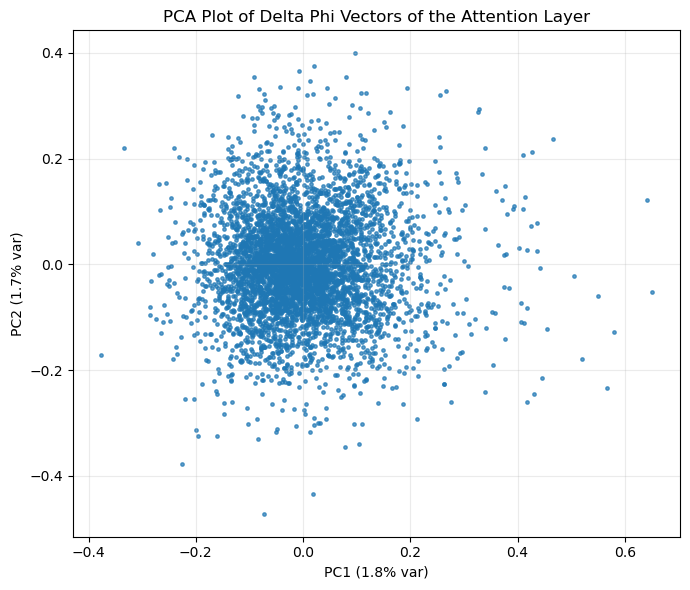

In [134]:
attention_delta_phi_X_pca, attention_delta_phi_pca = efficient_pca(attention_delta_phis,
                                                                    'PCA Plot of Delta Phi Vectors of the Attention Layer',
                                                                    'attention_delta_phi_vecs_pca.png',
                                                                    proj_dir=proj_dir,
                                                                    method="randomized")

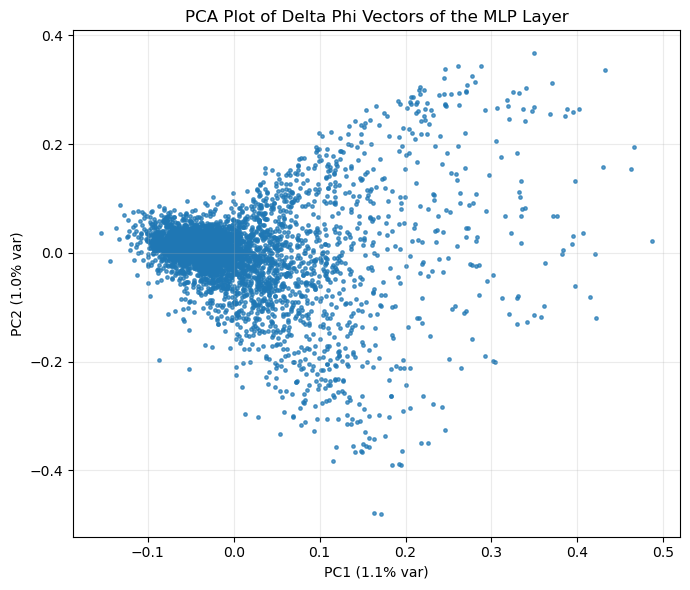

In [135]:
mlp_delta_phi_X_pca, mlp_delta_phi_pca = efficient_pca(mlp_delta_phis,
                                                       'PCA Plot of Delta Phi Vectors of the MLP Layer',
                                                       'mlp_delta_phi_vecs_pca.png',
                                                        proj_dir=proj_dir,
                                                        method="randomized")

### Clustering and Colored UMAP

#### Attention Layer

In [137]:
attention_delta_phi_pca_dims = 3750
attention_delta_phi_X_cluster_pca, attention_delta_phi_cluster_pca = efficient_pca(attention_delta_phis,
                                                                                    create_scatter = False,
                                                                                    method="randomized",
                                                                                    n_components = attention_delta_phi_pca_dims)

# Explained variance check
attention_ex_var_ratio = attention_delta_phi_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {attention_delta_phi_pca_dims} dimensions: {(attention_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 3750 dimensions: 95.3676%


Starting MiniBatchKMeans fitting for number of clusters between 5 and 150...


Fitting clusters: 100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


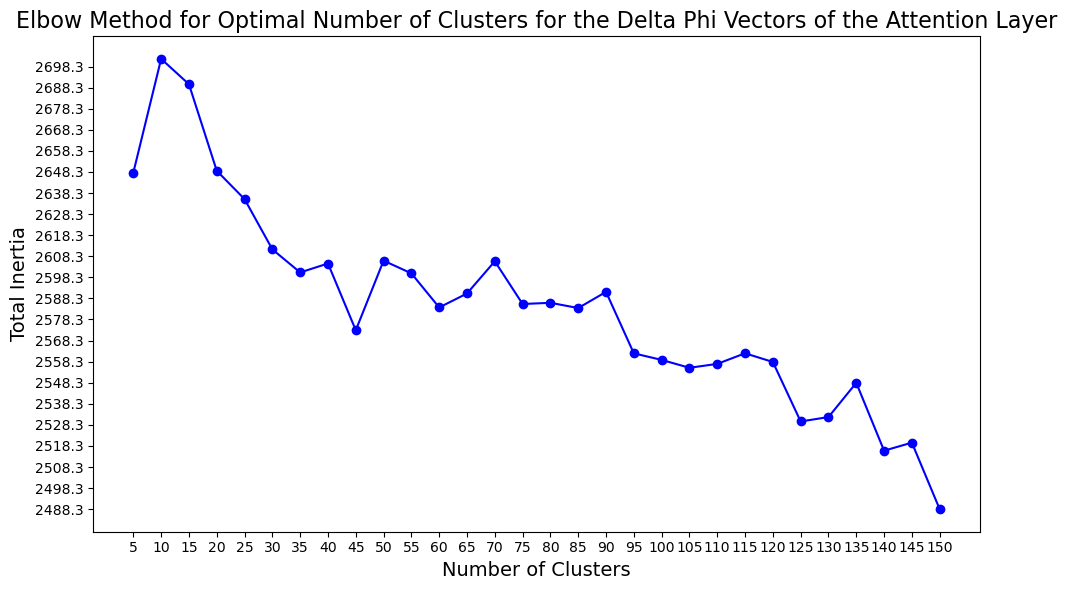

In [138]:
# Creating elbow plot for the Householder Vectors of the Attention Layer
create_elbow_plot(data = attention_delta_phi_X_cluster_pca,
                    elbow_plt_title = 'Elbow Method for Optimal Number of Clusters for the Delta Phi Vectors of the Attention Layer',
                    elbow_file_name = 'elbow_attention_delta_phi_vecs.png',
                    min_clusters = 5,
                    max_clusters = 150,
                    step = 5)

In [146]:
# Clustering the attention delta phi vectors

attention_delta_phi_X_cluster_pca = attention_delta_phi_X_cluster_pca.astype('float64')

n_clusters = 35
random_state_val = 42

# Initializing MiniBatchKMeans
attention_delta_phi_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
attention_delta_phi_kmeans.fit(attention_delta_phi_X_cluster_pca)

# Assigning each point to cluster
attention_delta_phi_color_labels = attention_delta_phi_kmeans.predict(attention_delta_phi_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 1912.7144309564244
[MiniBatchKMeans] Reassigning 29 cluster centers.
Minibatch step 1/146: mean batch inertia: 0.6185411484517108
[MiniBatchKMeans] Reassigning 30 cluster centers.
Minibatch step 2/146: mean batch inertia: 0.528720354110277, ewa inertia: 0.528720354110277
Minibatch step 3/146: mean batch inertia: 0.5347185687555678, ewa inertia: 0.5311767315534994
Minibatch step 4/146: mean batch inertia: 0.5262703151640299, ewa inertia: 0.5291674652536327
Minibatch step 5/146: mean batch inertia: 0.5179356217036775, ewa inertia: 0.5245678220642089
Minibatch step 6/146: mean batch inertia: 0.5335330758587026, ewa inertia: 0.5282392557316999
Minibatch step 7/146: mean batch inertia: 0.5276730074198555, ewa inertia: 0.5280073668009546
Minibatch step 8/146: mean batch inertia: 0.5398617238296584, ewa inertia: 0.5328619405251668
[MiniBatchKMeans] Reassigning 17 cluster centers.
Minibatch step 9/146: mean batch inertia: 0.5175186294979844,

In [147]:
np.bincount(attention_delta_phi_color_labels)

array([   1,   68,    1,    1,    1,    1,   23,    1,    1,    5,    1,
          1, 1538,    2,   33,  627,    1,    1,   50,    1,    1,    1,
         28,    1,  795,    7,  108,    1,  326,  242, 1126,    2,    1,
          1,    2])

/mmfs1/gscratch/stf/ipro13/conda_envs/quantum-conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


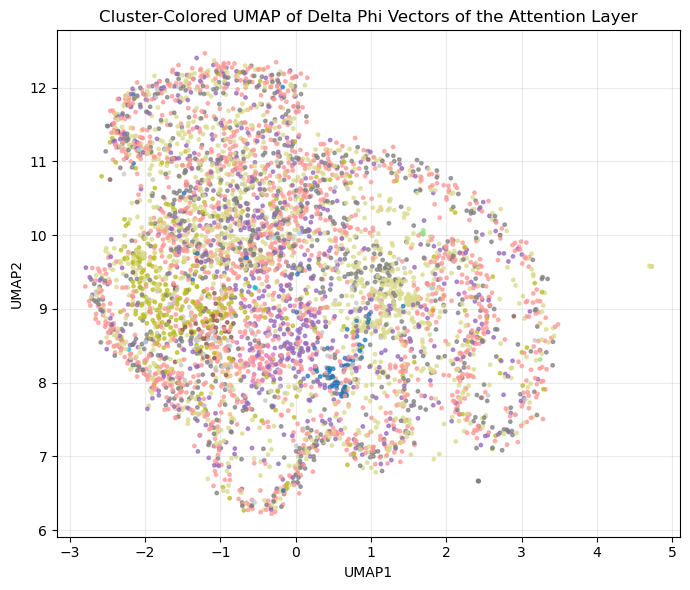

In [140]:
attention_clustered_delta_phi_X_umap, attention_clustered_delta_phi_umap = create_vec_scatter_umap(attention_delta_phi_X_cluster_pca,
                                                                                                  'Cluster-Colored UMAP of Delta Phi Vectors of the Attention Layer',
                                                                                                  'attention_delta_phi_vecs_clustered_umap.png',
                                                                                                  attention_delta_phi_color_labels,
                                                                                                  proj_dir = proj_dir)

#### MLP Layer

In [141]:
mlp_delta_phi_pca_dims = 3750
mlp_delta_phi_X_cluster_pca, mlp_delta_phi_cluster_pca = efficient_pca(mlp_delta_phis,
                                                                    create_scatter = False,
                                                                    method="randomized",
                                                                    n_components = mlp_delta_phi_pca_dims)

# Explained variance check
mlp_ex_var_ratio = mlp_delta_phi_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {mlp_delta_phi_pca_dims} dimensions: {(mlp_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 3750 dimensions: 93.4526%


Starting MiniBatchKMeans fitting for number of clusters between 5 and 150...


Fitting clusters: 100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


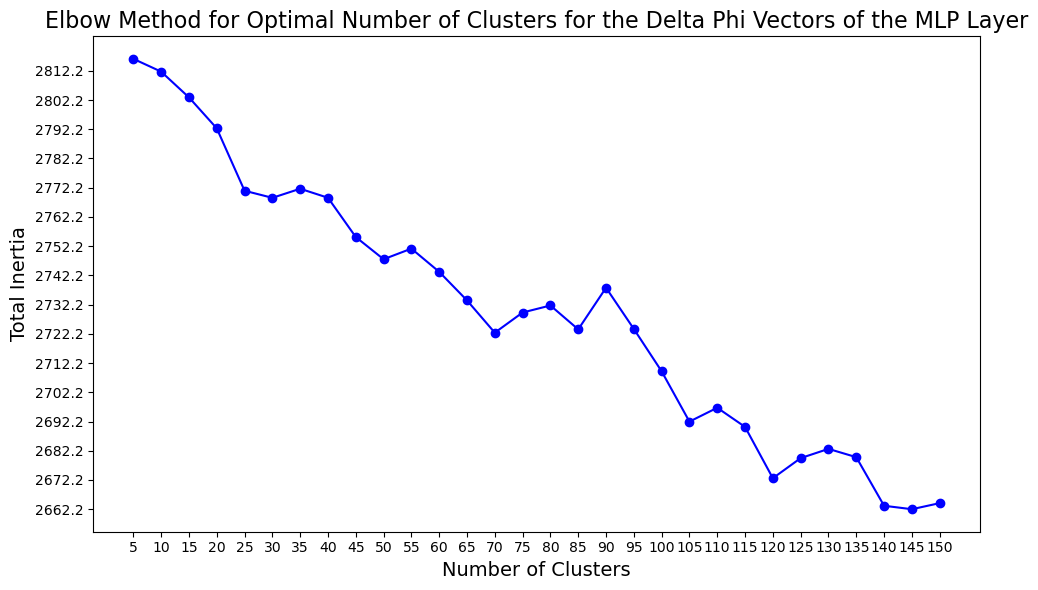

In [142]:
# Creating elbow plot for the Householder Vectors of the Attention Layer
create_elbow_plot(data = mlp_delta_phi_X_cluster_pca,
                    elbow_plt_title = 'Elbow Method for Optimal Number of Clusters for the Delta Phi Vectors of the MLP Layer',
                    elbow_file_name = 'elbow_mlp_delta_phi_vecs.png',
                    min_clusters = 5,
                    max_clusters = 150,
                    step = 5)

In [152]:
# Clustering the MLP delta phi vectors

mlp_delta_phi_X_cluster_pca = mlp_delta_phi_X_cluster_pca.astype('float64')

n_clusters = 30
random_state_val = 42

# Initializing MiniBatchKMeans
mlp_delta_phi_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
mlp_delta_phi_kmeans.fit(mlp_delta_phi_X_cluster_pca)

# Assigning each point to cluster
mlp_delta_phi_color_labels = mlp_delta_phi_kmeans.predict(mlp_delta_phi_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 2074.918486678058
[MiniBatchKMeans] Reassigning 25 cluster centers.
Minibatch step 1/146: mean batch inertia: 0.679669912217196
Minibatch step 2/146: mean batch inertia: 0.557908461942761, ewa inertia: 0.557908461942761
Minibatch step 3/146: mean batch inertia: 0.5643770195170462, ewa inertia: 0.5605574533269114
Minibatch step 4/146: mean batch inertia: 0.5579137679409226, ewa inertia: 0.5594748163202117
Minibatch step 5/146: mean batch inertia: 0.5639012646027143, ewa inertia: 0.5612875269945898
[MiniBatchKMeans] Reassigning 22 cluster centers.
Minibatch step 6/146: mean batch inertia: 0.5691907787372812, ewa inertia: 0.5645240516034744
[MiniBatchKMeans] Reassigning 24 cluster centers.
Minibatch step 7/146: mean batch inertia: 0.5526906758661075, ewa inertia: 0.5596780700977501
Minibatch step 8/146: mean batch inertia: 0.552650958865348, ewa inertia: 0.5568003408828012
[MiniBatchKMeans] Reassigning 19 cluster centers.
Minibatch step

In [153]:
np.bincount(mlp_delta_phi_color_labels)

array([2404,   54,  503,    1,    2,    1,    1,    1,    1,    6,  358,
          1,    1,    1,    1,    1,    1,  927,    1,    2,    1,  304,
          1,    1,    1,   14,    1,    1,    1,  407])

/mmfs1/gscratch/stf/ipro13/conda_envs/quantum-conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


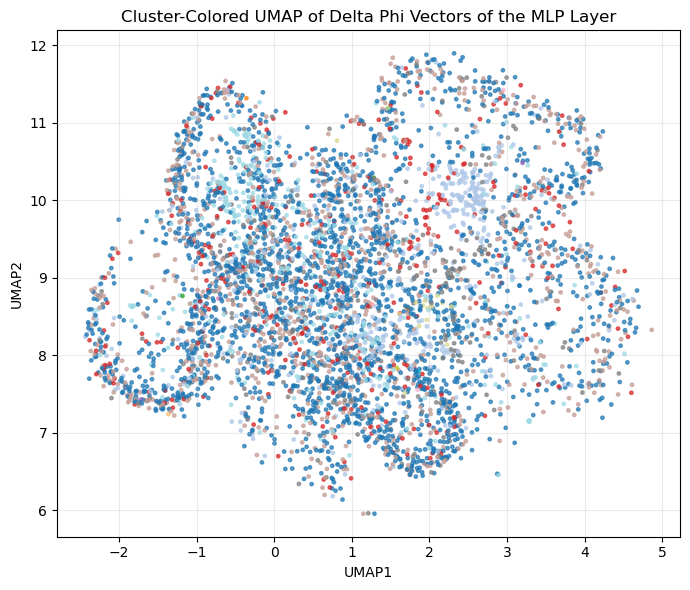

In [154]:
mlp_clustered_delta_phi_X_umap, mlp_clustered_delta_phi_umap = create_vec_scatter_umap(mlp_delta_phi_X_cluster_pca,
                                                                                      'Cluster-Colored UMAP of Delta Phi Vectors of the MLP Layer',
                                                                                      'mlp_delta_phi_vecs_clustered_umap.png',
                                                                                      mlp_delta_phi_color_labels,
                                                                                      proj_dir = proj_dir)